In [522]:
!pip install deap

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [523]:
!pip install bitstring

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [524]:
!pip install transforms3d

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [525]:
!pip install tsaug

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [526]:
import os
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from scipy import stats 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray
from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse

from math import sqrt
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

In [527]:
pwd

'/kaggle/working'

In [528]:
#%%time 
#!wget -O owid-covid-data.csv https://covid.ourworldindata.org/data/owid-covid-data.csv

In [529]:
df = pd.read_csv('../input/covid-maroc-until-august-15/owid-covid-data-maroc-August-15.csv') # having First.csv zipped file.

In [530]:
# Informations dur les données
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36557 entries, 0 to 36556
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   iso_code                         36493 non-null  object 
 1   continent                        36266 non-null  object 
 2   location                         36557 non-null  object 
 3   date                             36557 non-null  object 
 4   total_cases                      36212 non-null  float64
 5   new_cases                        36212 non-null  float64
 6   total_deaths                     36212 non-null  float64
 7   new_deaths                       36212 non-null  float64
 8   total_cases_per_million          36148 non-null  float64
 9   new_cases_per_million            36148 non-null  float64
 10  total_deaths_per_million         36148 non-null  float64
 11  new_deaths_per_million           36148 non-null  float64
 12  new_tests         

In [531]:
# Les 5 premères lignes du dataset 
df.head(5)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [532]:
df[df.continent  == 'Africa'].shape
# soit 54 pays en afrique ,3 mois de COVID = approximativement 4800

(8304, 36)

In [533]:
#Taille des données de COVID pour le Maroc
df[df.location  == 'Morocco'].shape

(189, 36)

In [534]:
#Première date d'enregistrement de cas dans le monde 
df.date.min()

'2019-12-31'

In [535]:
# dernière date d'enregistrement pour notre datset
df.date.max()

'2020-08-13'

In [536]:
# Première date d'enregistrement de cas au Maroc 
df[(df.location  == 'Morocco')].date.min()

'2020-02-07'

In [537]:
# dernière date d'enregistrement de cas au Maroc 
df[(df.location  == 'Morocco')].date.max()

'2020-08-13'

In [538]:
df.date= pd.to_datetime(df['date'],format='%Y-%m-%d')

In [539]:
df=df[['new_cases','total_cases','total_deaths','new_deaths', 'population','date','location']]


In [540]:
df = df.fillna(df.median())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


In [541]:
df[(df.location  == 'Morocco')].tail(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
22816,659.0,26196.0,401.0,19.0,36910558.0,2020-08-04,Morocco
22817,1021.0,27217.0,417.0,16.0,36910558.0,2020-08-05,Morocco
22818,1283.0,28500.0,435.0,18.0,36910558.0,2020-08-06,Morocco
22819,1144.0,29644.0,449.0,14.0,36910558.0,2020-08-07,Morocco
22820,1018.0,30662.0,461.0,12.0,36910558.0,2020-08-08,Morocco
22821,1345.0,32007.0,480.0,19.0,36910558.0,2020-08-09,Morocco
22822,1230.0,33237.0,498.0,18.0,36910558.0,2020-08-10,Morocco
22823,826.0,34063.0,516.0,18.0,36910558.0,2020-08-11,Morocco
22824,1132.0,35195.0,533.0,17.0,36910558.0,2020-08-12,Morocco
22825,1499.0,36694.0,556.0,23.0,36910558.0,2020-08-13,Morocco


In [542]:
def DA_Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    myNoise =  np.add(myNoise,abs(np.min(myNoise)))
    return X+myNoise

In [543]:
def DA_Scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    scalingFactor = np.add(scalingFactor,abs(np.min(scalingFactor)))
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise

In [544]:
def DA_Rotation(X):
    axis = np.random.uniform(low=-1, high=1, size=X.shape[1])
    angle = np.random.uniform(low=-np.pi, high=np.pi)
    return np.matmul(X , axangle2mat(axis,angle))

In [545]:
#df['month'] = df['date'].dt.month

In [546]:
nb_seq=4
n_out=7
nb_col=5

In [547]:
start_date = '2020-03-02'
end_date = '2020-05-24'
start_date2 = '2020-05-25'
end_date2 = '2020-06-14'

In [548]:
#mask = (covid_data['date'] >= start_date) & (covid_data['date'] <= end_date) &  (covid_data['location'].isin(['Morocco']))
mask1 = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))

In [549]:
mask2 = (df['date'] >= start_date2) & (df['date'] <= end_date2) &  (df['location'].isin(['Morocco']))

In [550]:
df.sort_values(by=['location'], inplace=True)


In [551]:
X_train = df.loc[mask1].sort_index(axis = 0) 
X_train.shape

(84, 7)

In [552]:
X_train.head(5)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
22661,6.0,589.0,10.0,0.0,36910558.0,2020-03-02,Morocco
22662,1.0,1.0,0.0,0.0,36910558.0,2020-03-03,Morocco
22663,6.0,589.0,10.0,0.0,36910558.0,2020-03-04,Morocco
22664,6.0,589.0,10.0,0.0,36910558.0,2020-03-05,Morocco
22665,1.0,2.0,0.0,0.0,36910558.0,2020-03-06,Morocco


In [553]:
X_train.tail(5)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
22740,71.0,7023.0,193.0,1.0,36910558.0,2020-05-20,Morocco
22741,110.0,7133.0,194.0,1.0,36910558.0,2020-05-21,Morocco
22742,78.0,7211.0,196.0,2.0,36910558.0,2020-05-22,Morocco
22743,121.0,7332.0,197.0,1.0,36910558.0,2020-05-23,Morocco
22744,74.0,7406.0,198.0,1.0,36910558.0,2020-05-24,Morocco


In [554]:
#Date to add test set 
data_add_test = X_train[X_train.location =='Morocco'].tail(nb_seq)

In [555]:
'''
# AUGMENTATION 

start_date = '2020-06-25'
end_date = '2020-07-31'
mask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))
X_1 = df.loc[mask].sort_index(axis = 0) 
X_2 = X_3 = X_4 =X_5=X_6=X_7=X_8= X_1

X_2[['new_cases']] = DA_Jitter(X_2[['new_cases']], sigma=1000)
X_2[['total_cases']] = X_2['total_cases'] + X_2['new_cases']
X_2[['new_deaths']] = DA_Jitter(X_2[['new_deaths']], sigma=10)
X_2[['total_deaths']] = X_2['total_deaths'] + X_2['new_deaths']

X_3[['new_cases']] = DA_Jitter(X_3[['new_cases']], sigma=500)
X_3[['total_cases']] = X_3['total_cases'] + X_3['new_cases']
X_3[['new_deaths']] = DA_Jitter(X_3['new_deaths'], sigma=20)
X_3[['total_deaths']] = X_3['total_deaths'] + X_3['new_deaths']

X_4[['new_cases']] = DA_Jitter(X_4[['new_cases']], sigma=1000)
X_4[['total_cases']] = X_4['total_cases'] + X_4['new_cases']
X_4[['new_deaths']] = DA_Jitter(X_4[['new_deaths']], sigma=30)
X_4[['total_deaths']] = X_4['total_deaths'] + X_4['new_deaths']

X_5[['new_cases']] = DA_Jitter(X_5[['new_cases']], sigma=1000)
X_5[['total_cases']] = X_5['total_cases'] + X_5['new_cases']
X_5[['new_deaths']] = DA_Jitter(X_5[['new_deaths']], sigma=40)
X_5[['total_deaths']] = X_5['total_deaths'] + X_5['new_deaths']

X_6[['new_cases']] = DA_Jitter(X_6[['new_cases']], sigma=1000)
X_6[['total_cases']] = X_6['total_cases'] + X_6['new_cases']
X_6[['new_deaths']] = DA_Jitter(X_6[['new_deaths']], sigma=50)
X_6[['total_deaths']] = X_6['total_deaths'] + X_6['new_deaths']


#X_7[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']] = DA_Scaling(X_6[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']], sigma=2000)
#X_8[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']] = DA_Scaling(X_7[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']], sigma=3000)
#X_4 = pd.DataFrame(X_4,columns=cols_need)
#print(X_1.shape)
X_train = pd.concat([X_train, X_2,X_3,X_4,X_5,X_6], ignore_index=True)
'''

"\n# AUGMENTATION \n\nstart_date = '2020-06-25'\nend_date = '2020-07-31'\nmask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))\nX_1 = df.loc[mask].sort_index(axis = 0) \nX_2 = X_3 = X_4 =X_5=X_6=X_7=X_8= X_1\n\nX_2[['new_cases']] = DA_Jitter(X_2[['new_cases']], sigma=1000)\nX_2[['total_cases']] = X_2['total_cases'] + X_2['new_cases']\nX_2[['new_deaths']] = DA_Jitter(X_2[['new_deaths']], sigma=10)\nX_2[['total_deaths']] = X_2['total_deaths'] + X_2['new_deaths']\n\nX_3[['new_cases']] = DA_Jitter(X_3[['new_cases']], sigma=500)\nX_3[['total_cases']] = X_3['total_cases'] + X_3['new_cases']\nX_3[['new_deaths']] = DA_Jitter(X_3['new_deaths'], sigma=20)\nX_3[['total_deaths']] = X_3['total_deaths'] + X_3['new_deaths']\n\nX_4[['new_cases']] = DA_Jitter(X_4[['new_cases']], sigma=1000)\nX_4[['total_cases']] = X_4['total_cases'] + X_4['new_cases']\nX_4[['new_deaths']] = DA_Jitter(X_4[['new_deaths']], sigma=30)\nX_4[['total_deaths']] = X_4['total_deaths'

In [556]:
X_train.shape

(84, 7)

In [557]:
X_train.head(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
22661,6.0,589.0,10.0,0.0,36910558.0,2020-03-02,Morocco
22662,1.0,1.0,0.0,0.0,36910558.0,2020-03-03,Morocco
22663,6.0,589.0,10.0,0.0,36910558.0,2020-03-04,Morocco
22664,6.0,589.0,10.0,0.0,36910558.0,2020-03-05,Morocco
22665,1.0,2.0,0.0,0.0,36910558.0,2020-03-06,Morocco
22666,6.0,589.0,10.0,0.0,36910558.0,2020-03-07,Morocco
22667,6.0,589.0,10.0,0.0,36910558.0,2020-03-08,Morocco
22668,6.0,589.0,10.0,0.0,36910558.0,2020-03-09,Morocco
22669,6.0,589.0,10.0,0.0,36910558.0,2020-03-10,Morocco
22670,6.0,589.0,10.0,0.0,36910558.0,2020-03-11,Morocco


In [558]:
X_train.tail(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
22735,95.0,6607.0,190.0,2.0,36910558.0,2020-05-15,Morocco
22736,45.0,6652.0,190.0,0.0,36910558.0,2020-05-16,Morocco
22737,89.0,6741.0,192.0,2.0,36910558.0,2020-05-17,Morocco
22738,129.0,6870.0,192.0,0.0,36910558.0,2020-05-18,Morocco
22739,82.0,6952.0,192.0,0.0,36910558.0,2020-05-19,Morocco
22740,71.0,7023.0,193.0,1.0,36910558.0,2020-05-20,Morocco
22741,110.0,7133.0,194.0,1.0,36910558.0,2020-05-21,Morocco
22742,78.0,7211.0,196.0,2.0,36910558.0,2020-05-22,Morocco
22743,121.0,7332.0,197.0,1.0,36910558.0,2020-05-23,Morocco
22744,74.0,7406.0,198.0,1.0,36910558.0,2020-05-24,Morocco


In [559]:
X_test = df.loc[mask2].sort_index(axis = 0) 

X_test.shape

(21, 7)

In [560]:
X_test = pd.concat([pd.DataFrame(data_add_test),X_test], ignore_index=True)
X_test = X_test.sort_index(axis = 0)

In [561]:
X_test

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
0,110.0,7133.0,194.0,1.0,36910558.0,2020-05-21,Morocco
1,78.0,7211.0,196.0,2.0,36910558.0,2020-05-22,Morocco
2,121.0,7332.0,197.0,1.0,36910558.0,2020-05-23,Morocco
3,74.0,7406.0,198.0,1.0,36910558.0,2020-05-24,Morocco
4,27.0,7433.0,199.0,1.0,36910558.0,2020-05-25,Morocco
5,99.0,7532.0,200.0,1.0,36910558.0,2020-05-26,Morocco
6,45.0,7577.0,202.0,2.0,36910558.0,2020-05-27,Morocco
7,24.0,7601.0,202.0,0.0,36910558.0,2020-05-28,Morocco
8,42.0,7643.0,202.0,0.0,36910558.0,2020-05-29,Morocco
9,71.0,7714.0,202.0,0.0,36910558.0,2020-05-30,Morocco


In [562]:
X_test['timestamp'] = pd.to_datetime(X_test['date'], infer_datetime_format=True)
X_test.set_index('timestamp', inplace=True)

X_train['timestamp'] = pd.to_datetime(X_train['date'], infer_datetime_format=True)
X_train.set_index('timestamp', inplace=True)

In [563]:
X_train=X_train[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']]

X_test=X_test[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']]
Y_test=X_test[['new_cases']]

Y_train=X_train[['new_cases']]

In [564]:
days=X_test[nb_seq:].index
days=days.sort_values()

In [565]:
#days=days[nb_seq:]

In [566]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(84, 5)
(84, 1)
(25, 5)
(25, 1)


In [567]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler2= MinMaxScaler(feature_range=(0, 1))

In [568]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [569]:

X_train=X_train
X_test=X_test
Y_train=Y_train
Y_test=Y_test

# ensure all data is float
X_train = X_train.astype('float32')
# ensure all data is float
X_test = X_test.astype('float32')
# ensure all data is float
Y_test = Y_test.astype('float32')
# ensure all data is float
Y_train = Y_train.astype('float32')

# normalize features

X_train= scaler.fit_transform(X_train)
X_test= scaler.fit_transform(X_test)
Y_train= scaler2.fit_transform(Y_train)
Y_test= scaler2.fit_transform(Y_test)

# reframe as supervised learning
# on doit toujours vers une conversion vers n_out ensuite con choisit le nombre de colonnes dont nous avons besoins
X_train = series_to_supervised(X_train, nb_seq, n_out)
X_test = series_to_supervised(X_test, nb_seq, n_out)
print(X_train)
print(X_train.shape)
print(X_test.shape)
Y_train = series_to_supervised(Y_train, nb_seq, n_out)
Y_test = series_to_supervised(Y_test, nb_seq, n_out)
print(Y_train.shape)
print(Y_test.shape)


    var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var1(t-3)  \
4    0.021352   0.079406   0.050505   0.000000        0.0   0.003559   
5    0.003559   0.000000   0.000000   0.000000        0.0   0.021352   
6    0.021352   0.079406   0.050505   0.000000        0.0   0.021352   
7    0.021352   0.079406   0.050505   0.000000        0.0   0.003559   
8    0.003559   0.000135   0.000000   0.000000        0.0   0.021352   
..        ...        ...        ...        ...        ...        ...   
73   0.708185   0.797974   0.939394   0.000000        0.0   0.544484   
74   0.544484   0.818636   0.949495   0.133333        0.0   0.775801   
75   0.775801   0.848076   0.949495   0.000000        0.0   0.487544   
76   0.487544   0.866577   0.949495   0.000000        0.0   0.334520   
77   0.334520   0.879271   0.949495   0.000000        0.0   0.338078   

    var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  ...  var1(t+5)  var2(t+5)  \
4    0.000000   0.000000   0.000000        0.0  ...   0.02

In [570]:
print(X_test)

    var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)  var1(t-3)  \
4    0.786325   0.000000   0.000000        0.5        0.0   0.512821   
5    0.512821   0.050032   0.111112        1.0        0.0   0.880342   
6    0.880342   0.127646   0.166667        0.5        0.0   0.478633   
7    0.478633   0.175112   0.222222        0.5        0.0   0.076923   
8    0.076923   0.192431   0.277778        0.5        0.0   0.692308   
9    0.692308   0.255933   0.333334        0.5        0.0   0.230769   
10   0.230769   0.284798   0.444445        1.0        0.0   0.051282   
11   0.051282   0.300192   0.444445        0.0        0.0   0.205128   
12   0.205128   0.327133   0.444445        0.0        0.0   0.452991   
13   0.452991   0.372675   0.444445        0.0        0.0   0.410256   
14   0.410256   0.415009   0.555555        1.0        0.0   0.076923   
15   0.076923   0.432329   0.611112        0.5        0.0   0.068376   
16   0.068376   0.449006   0.611112        0.0        0.0   0.12

In [571]:
#col_y_need_train = df.filter(regex=("d.*"))

In [572]:
#col_y_need_train=X_train.columns[[35,40,45,50,55,60,65]]
#col_y_need_test=X_test.columns[[35,40,45,50,55,60,65]]
X_train

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),...,var1(t+5),var2(t+5),var3(t+5),var4(t+5),var5(t+5),var1(t+6),var2(t+6),var3(t+6),var4(t+6),var5(t+6)
4,0.021352,0.079406,0.050505,0.000000,0.0,0.003559,0.000000,0.000000,0.000000,0.0,...,0.021352,0.079406,0.050505,0.000000,0.0,0.010676,0.000540,0.005051,0.066667,0.0
5,0.003559,0.000000,0.000000,0.000000,0.0,0.021352,0.079406,0.050505,0.000000,0.0,...,0.010676,0.000540,0.005051,0.066667,0.0,0.003559,0.000675,0.005051,0.000000,0.0
6,0.021352,0.079406,0.050505,0.000000,0.0,0.021352,0.079406,0.050505,0.000000,0.0,...,0.003559,0.000675,0.005051,0.000000,0.0,0.003559,0.000810,0.005051,0.000000,0.0
7,0.021352,0.079406,0.050505,0.000000,0.0,0.003559,0.000135,0.000000,0.000000,0.0,...,0.003559,0.000810,0.005051,0.000000,0.0,0.039146,0.002296,0.005051,0.000000,0.0
8,0.003559,0.000135,0.000000,0.000000,0.0,0.021352,0.079406,0.050505,0.000000,0.0,...,0.039146,0.002296,0.005051,0.000000,0.0,0.035587,0.003646,0.005051,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,0.708185,0.797974,0.939394,0.000000,0.0,0.544484,0.818636,0.949495,0.133333,0.0,...,0.291815,0.938690,0.969697,0.000000,0.0,0.252669,0.948278,0.974747,0.066667,0.0
74,0.544484,0.818636,0.949495,0.133333,0.0,0.775801,0.848076,0.949495,0.000000,0.0,...,0.252669,0.948278,0.974747,0.066667,0.0,0.391459,0.963133,0.979798,0.066667,0.0
75,0.775801,0.848076,0.949495,0.000000,0.0,0.487544,0.866577,0.949495,0.000000,0.0,...,0.391459,0.963133,0.979798,0.066667,0.0,0.277580,0.973666,0.989899,0.133333,0.0
76,0.487544,0.866577,0.949495,0.000000,0.0,0.334520,0.879271,0.949495,0.000000,0.0,...,0.277580,0.973666,0.989899,0.133333,0.0,0.430605,0.990007,0.994950,0.066667,0.0


In [573]:
Y_train.head(5)

,var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
4,0.021352,0.003559,0.021352,0.021352,0.003559,0.021352,0.021352,0.021352,0.021352,0.021352,0.010676
5,0.003559,0.021352,0.021352,0.003559,0.021352,0.021352,0.021352,0.021352,0.021352,0.010676,0.003559
6,0.021352,0.021352,0.003559,0.021352,0.021352,0.021352,0.021352,0.021352,0.010676,0.003559,0.003559
7,0.021352,0.003559,0.021352,0.021352,0.021352,0.021352,0.021352,0.010676,0.003559,0.003559,0.039146
8,0.003559,0.021352,0.021352,0.021352,0.021352,0.021352,0.010676,0.003559,0.003559,0.039146,0.035587


In [574]:
#raise SystemExit("Stop right there!")

In [575]:
# regex : var[1-i]\(t\-\d{1,2}\)$
#i = 1 if nb_seq== 7 else 2 if nb_seq== 6 else 3 if nb_seq== 5 else 4 if nb_seq== 4 else 5 if nb_seq== 3 else 6 if nb_seq== 2 else 7 if nb_seq== 1 else 0
col_take= 'var[1-j]\(t\-[1-i]\)$'
col_take = col_take.replace("i", str(nb_seq))
col_take = col_take.replace("j", str(nb_col))
regex_find = col_take

In [576]:
col_x_need_train =X_train.filter(regex=regex_find,axis=1).head(1)

In [577]:
col_x_need_train

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
4,0.021352,0.079406,0.050505,0.0,0.0,0.003559,0.0,0.0,0.0,0.0,0.021352,0.079406,0.050505,0.0,0.0,0.021352,0.079406,0.050505,0.0,0.0


In [578]:
#col_take2= 'var[1-i](\(t\+\d{1}\)|(\(t\)))$'
col_take2= 'var1(\(t\+\d{1}\)|(\(t\)))$'
#col_take2 = col_take2.replace("i", str(nb_seq))
regex_find2 = col_take2
Y_train.filter(regex=regex_find2,axis=1).head(1)

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
4,0.003559,0.021352,0.021352,0.021352,0.021352,0.021352,0.010676


In [579]:
#raise SystemExit("Stop right there!")

In [580]:
#col_x_need_train=X_train.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]
#col_x_need_test=X_test.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]

In [581]:
#col_x_need_train

In [582]:
# drop columns we don't want to predict
Y_train = Y_train.filter(regex='var[1-7](\(t\+\d{1}\)|(\(t\)))$',axis=1)
Y_test=Y_test.filter(regex='var[1-7](\(t\+\d{1}\)|(\(t\)))$',axis=1)
Y_train
print(Y_train.shape)
print(Y_test.shape)


(74, 7)
(15, 7)


In [583]:
Y_train.head(5)

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
4,0.003559,0.021352,0.021352,0.021352,0.021352,0.021352,0.010676
5,0.021352,0.021352,0.021352,0.021352,0.021352,0.010676,0.003559
6,0.021352,0.021352,0.021352,0.021352,0.010676,0.003559,0.003559
7,0.021352,0.021352,0.021352,0.010676,0.003559,0.003559,0.039146
8,0.021352,0.021352,0.010676,0.003559,0.003559,0.039146,0.035587


In [584]:
# drop columns we don't want to predict
X_train = X_train.filter(regex=regex_find,axis=1)
X_test=X_test.filter(regex=regex_find,axis=1)
print(X_train.shape)
print(X_test.shape)
X_train


(74, 20)
(15, 20)


,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
4,0.021352,0.079406,0.050505,0.000000,0.0,0.003559,0.000000,0.000000,0.000000,0.0,0.021352,0.079406,0.050505,0.000000,0.0,0.021352,0.079406,0.050505,0.000000,0.0
5,0.003559,0.000000,0.000000,0.000000,0.0,0.021352,0.079406,0.050505,0.000000,0.0,0.021352,0.079406,0.050505,0.000000,0.0,0.003559,0.000135,0.000000,0.000000,0.0
6,0.021352,0.079406,0.050505,0.000000,0.0,0.021352,0.079406,0.050505,0.000000,0.0,0.003559,0.000135,0.000000,0.000000,0.0,0.021352,0.079406,0.050505,0.000000,0.0
7,0.021352,0.079406,0.050505,0.000000,0.0,0.003559,0.000135,0.000000,0.000000,0.0,0.021352,0.079406,0.050505,0.000000,0.0,0.021352,0.079406,0.050505,0.000000,0.0
8,0.003559,0.000135,0.000000,0.000000,0.0,0.021352,0.079406,0.050505,0.000000,0.0,0.021352,0.079406,0.050505,0.000000,0.0,0.021352,0.079406,0.050505,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,0.708185,0.797974,0.939394,0.000000,0.0,0.544484,0.818636,0.949495,0.133333,0.0,0.775801,0.848076,0.949495,0.000000,0.0,0.487544,0.866577,0.949495,0.000000,0.0
74,0.544484,0.818636,0.949495,0.133333,0.0,0.775801,0.848076,0.949495,0.000000,0.0,0.487544,0.866577,0.949495,0.000000,0.0,0.334520,0.879271,0.949495,0.000000,0.0
75,0.775801,0.848076,0.949495,0.000000,0.0,0.487544,0.866577,0.949495,0.000000,0.0,0.334520,0.879271,0.949495,0.000000,0.0,0.338078,0.892100,0.959596,0.133333,0.0
76,0.487544,0.866577,0.949495,0.000000,0.0,0.334520,0.879271,0.949495,0.000000,0.0,0.338078,0.892100,0.959596,0.133333,0.0,0.160142,0.898177,0.959596,0.000000,0.0


In [585]:
X_test

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
4,0.786325,0.000000,0.000000,0.5,0.0,0.512821,0.050032,0.111112,1.0,0.0,0.880342,0.127646,0.166667,0.5,0.0,0.478633,0.175112,0.222222,0.5,0.0
5,0.512821,0.050032,0.111112,1.0,0.0,0.880342,0.127646,0.166667,0.5,0.0,0.478633,0.175112,0.222222,0.5,0.0,0.076923,0.192431,0.277778,0.5,0.0
6,0.880342,0.127646,0.166667,0.5,0.0,0.478633,0.175112,0.222222,0.5,0.0,0.076923,0.192431,0.277778,0.5,0.0,0.692308,0.255933,0.333334,0.5,0.0
7,0.478633,0.175112,0.222222,0.5,0.0,0.076923,0.192431,0.277778,0.5,0.0,0.692308,0.255933,0.333334,0.5,0.0,0.230769,0.284798,0.444445,1.0,0.0
8,0.076923,0.192431,0.277778,0.5,0.0,0.692308,0.255933,0.333334,0.5,0.0,0.230769,0.284798,0.444445,1.0,0.0,0.051282,0.300192,0.444445,0.0,0.0
9,0.692308,0.255933,0.333334,0.5,0.0,0.230769,0.284798,0.444445,1.0,0.0,0.051282,0.300192,0.444445,0.0,0.0,0.205128,0.327133,0.444445,0.0,0.0
10,0.230769,0.284798,0.444445,1.0,0.0,0.051282,0.300192,0.444445,0.0,0.0,0.205128,0.327133,0.444445,0.0,0.0,0.452991,0.372675,0.444445,0.0,0.0
11,0.051282,0.300192,0.444445,0.0,0.0,0.205128,0.327133,0.444445,0.0,0.0,0.452991,0.372675,0.444445,0.0,0.0,0.410256,0.415009,0.555555,1.0,0.0
12,0.205128,0.327133,0.444445,0.0,0.0,0.452991,0.372675,0.444445,0.0,0.0,0.410256,0.415009,0.555555,1.0,0.0,0.076923,0.432329,0.611112,0.5,0.0
13,0.452991,0.372675,0.444445,0.0,0.0,0.410256,0.415009,0.555555,1.0,0.0,0.076923,0.432329,0.611112,0.5,0.0,0.068376,0.449006,0.611112,0.0,0.0


In [586]:
print(X_test.shape)

(15, 20)


In [587]:
nb_col=5

In [588]:
X_test.head(1)

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
4,0.786325,0.0,0.0,0.5,0.0,0.512821,0.050032,0.111112,1.0,0.0,0.880342,0.127646,0.166667,0.5,0.0,0.478633,0.175112,0.222222,0.5,0.0


In [589]:

X_train=X_train.values
X_test=X_test.values

Y_train=Y_train.values
Y_test=Y_test.values

# reshape input to be 3D [samples, timesteps, features]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)


(15, 1, 20) (15, 7) (74, 1, 20) (74, 7)


In [590]:
'''
n_input = X_train.shape[1] * X_train.shape[2]
X_train= X_train.reshape((X_train.shape[0], n_input))
n_input2 = X_test.shape[1] * X_test.shape[2]
X_test= X_test.reshape((X_test.shape[0], n_input2))
'''
print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)

(15, 1, 20) (15, 7) (74, 1, 20) (74, 7)


In [591]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [592]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [637]:
best_score = 0
best_sequence = 0
model_name=  ''
history_model= ''

In [638]:
from tensorflow.keras.callbacks import EarlyStopping
import math
from math import sqrt
dropout_tab =[0.0,0.15,0.2,0.25,0.4,0.45,0.5,0.6]
def train_evaluate(ga_individual_solution): 
    global best_score, model_name ,best_sequence ,sequences_size
    
    # Decode GA solution to integer for window_size and num_units
    cnn_units1_bits = BitArray(ga_individual_solution[0:7])
    #cnn_units2_bits = BitArray(ga_individual_solution[7:14])
    #cnn_units3_bits = BitArray(ga_individual_solution[15:22])
    cnn_units1 = cnn_units1_bits.uint
    #cnn_units2 =  cnn_units2_bits.uint
    #cnn_units3 =  cnn_units3_bits.uint

    cnn_units1 = 1 if cnn_units1 == 0  else cnn_units1
    #cnn_units2  = 1 if cnn_units2 == 0  else cnn_units2 

    #print('\nUnits CNN1: ',cnn_units1,'Units CNN2: ',cnn_units2,',Sequence size: ',nb_seq)
    print('\nUnits CNN1: ',cnn_units1,',Sequence size: ',nb_seq)
      
    # convert into input/output
    print(X_train.shape)
    model = keras.Sequential()  
 
    #initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)   
    model.add(layers.Conv1D(cnn_units1,2,padding='same',strides=1, activation='tanh' ,input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(layers.Conv1D(cnn_units2,2,padding='same',strides=1, activation='relu'))
    #model.add(layers.Conv1D(cnn_units3,2,padding='same',strides=1, activation='tanh'))
    model.add(layers.Flatten())
    #model.add(Dense(100))
    #model.add(Dense(50))
    #model.add(Dense(cnn_units3))
    #model.add(Dense(cnn_units3))
    #model.add(Dropout(0.1))
    model.add(Dense(n_out))

    '''
    model.add(LSTM(cnn_units1, activation='relu',return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(cnn_units2, activation='relu'))
    model.add(Dense(n_out))
    '''
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X_train, Y_train, epochs=6,batch_size=1, validation_data=(X_test[[0,7,14]], Y_test[[0,7,14]]), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=20)], verbose=1)
    model.summary()
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    pred_train = model.predict(X_train)
    print(pred_train.shape)
    pred_train = pred_train.reshape(-1,n_out)

    print(Y_train.shape)
    print(pred_train.shape)
    score_train ,scores_train = evaluate_forecasts(scaler2.inverse_transform(Y_train) ,scaler2.inverse_transform(pred_train))
    summarize_scores('score_train', score_train, scores_train) 
    
    #Normalisation des X
    print(X_test.shape)
    #Prédiction sur les données de Test
    prediction = model.predict(X_test[[0,7,14]]) 
    prediction = prediction.reshape(-1, n_out)

   
    score_test ,scores_test = evaluate_forecasts(scaler2.inverse_transform(Y_test[[0,7,14]]) ,scaler2.inverse_transform(prediction))
    summarize_scores('score_test', score_test, scores_test) 
    # le score 
    score_val = score_test
    best_score = score_val if best_score == 0 else best_score
    if(best_score >= score_val):
      best_score= score_val
      model_name= model
      history_model= history
    # Calculate the RMSE score as fitness score for GA
    #rmse =  np.sqrt(mean_squared_error(prediction_test.true_value, prediction_test.predict))
    print('\nRMSE test: ', score_test ,'\n')
    #print('Validation Score: ', score_val,'\n')
    
    return best_score,

/opt/conda/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/opt/conda/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)



Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0935
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0662
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0850
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0705
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0764
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0589
Model: "sequential_787"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_787 (Conv1D)          (None, 1, 127)            5207      
_________________________________________________________________
flatten_787 (Flatten)        (None, 127)               0         
_______________

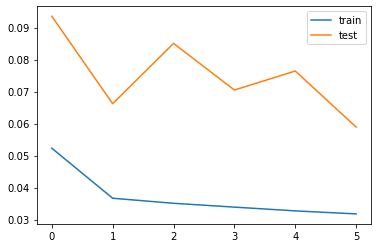

(74, 7)
(74, 7)
(74, 7)
score_train: [18.874] 17.9, 17.3, 18.7, 20.4, 20.3, 18.9, 18.3
(15, 1, 20)
score_test: [28.391] 31.5, 26.1, 47.8, 28.3, 21.4, 8.8, 18.7

RMSE test:  28.391245949125267 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0597 - val_loss: 0.0683
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0371 - val_loss: 0.0897
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0621
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.0575
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0587
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0731
Model: "sequential_788"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_788 (Conv1D)

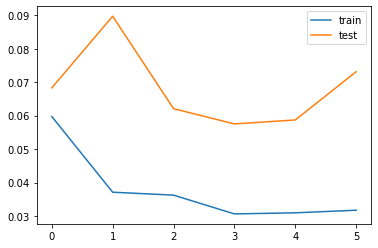

(74, 7)
(74, 7)
(74, 7)
score_train: [19.246] 16.8, 22.3, 18.5, 19.8, 20.1, 19.2, 17.4
(15, 1, 20)
score_test: [31.639] 28.4, 27.1, 48.0, 46.2, 28.4, 11.8, 9.2

RMSE test:  31.63876112832596 


Units CNN1:  125 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0687 - val_loss: 0.0728
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0739
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0387 - val_loss: 0.0690
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0878
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0647
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0856
Model: "sequential_789"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_789 (Conv1D) 

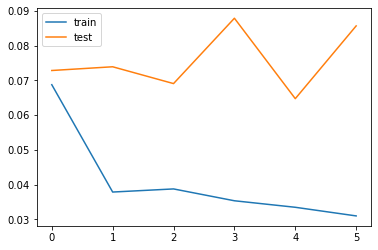

(74, 7)
(74, 7)
(74, 7)
score_train: [19.981] 17.5, 18.8, 18.4, 25.2, 20.2, 19.9, 18.8
(15, 1, 20)
score_test: [34.240] 34.9, 21.1, 42.3, 58.7, 32.9, 9.9, 11.1

RMSE test:  34.240205625256685 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0871 - val_loss: 0.0671
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0716
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0696
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0605
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0553
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0606
Model: "sequential_790"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_790 (Conv1D)

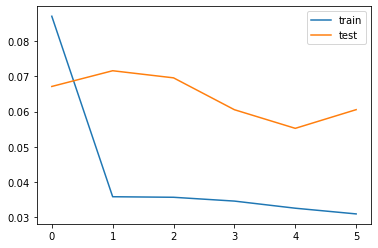

(74, 7)
(74, 7)
(74, 7)
score_train: [18.824] 16.9, 17.9, 18.3, 18.4, 19.6, 19.6, 20.8
(15, 1, 20)
score_test: [28.792] 30.2, 23.9, 42.5, 39.4, 24.8, 12.2, 14.0

RMSE test:  28.79165551302139 


Units CNN1:  63 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0557 - val_loss: 0.0844
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.1049
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.0930
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0913
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0845
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0804
Model: "sequential_791"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_791 (Conv1D) 

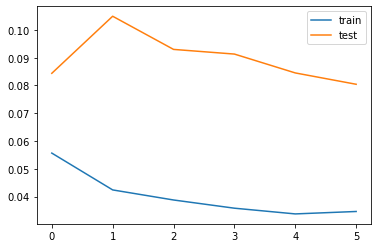

(74, 7)
(74, 7)
(74, 7)
score_train: [19.534] 17.8, 17.5, 18.3, 19.3, 20.9, 22.5, 19.9
(15, 1, 20)
score_test: [33.181] 37.4, 27.4, 47.5, 45.1, 29.0, 11.2, 17.4

RMSE test:  33.18120260509 


Units CNN1:  62 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0679 - val_loss: 0.0917
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0836
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0817
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0804
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0693
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.0612
Model: "sequential_792"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_792 (Conv1D)    

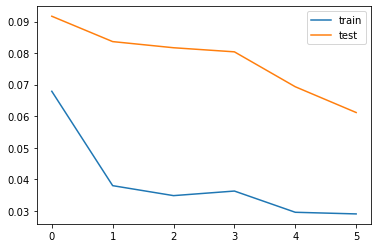

(74, 7)
(74, 7)
(74, 7)
score_train: [18.747] 17.0, 18.1, 19.7, 20.5, 19.4, 18.2, 18.0
(15, 1, 20)
score_test: [28.936] 32.6, 27.4, 48.8, 31.2, 23.5, 8.3, 8.3

RMSE test:  28.9357027727013 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 5ms/step - loss: 0.0552 - val_loss: 0.0810
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0815
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0724
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0645
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0705
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0610
Model: "sequential_793"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_793 (Conv1D)   

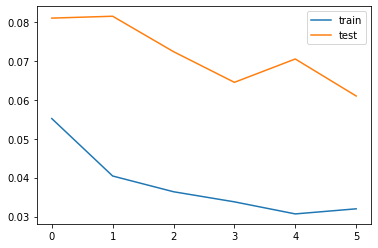

(74, 7)
(74, 7)
(74, 7)
score_train: [19.172] 16.7, 17.9, 21.1, 19.4, 19.1, 18.6, 21.1
(15, 1, 20)
score_test: [28.895] 23.8, 25.1, 48.4, 38.1, 23.0, 7.5, 16.4

RMSE test:  28.89499492599992 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0604 - val_loss: 0.0754
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0862
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0745
Epoch 4/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0326 - val_loss: 0.0675
Epoch 5/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0369 - val_loss: 0.0654
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0738
Model: "sequential_794"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_794 (Conv1D) 

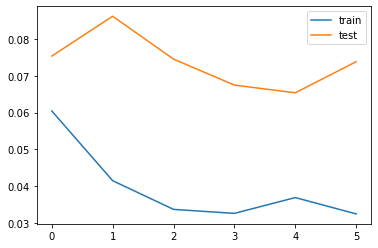

(74, 7)
(74, 7)
(74, 7)
score_train: [19.693] 16.6, 18.0, 18.4, 19.1, 26.3, 18.4, 19.4
(15, 1, 20)
score_test: [31.790] 30.7, 25.0, 42.2, 47.6, 32.0, 10.6, 18.0

RMSE test:  31.790050084624895 


Units CNN1:  122 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0671 - val_loss: 0.0580
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0906
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0645
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0673
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0330 - val_loss: 0.0672
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0639
Model: "sequential_795"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_795 (Conv1D

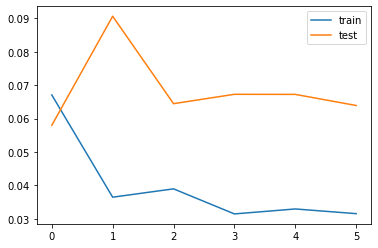

(74, 7)
(74, 7)
(74, 7)
score_train: [18.654] 18.8, 18.7, 19.5, 18.9, 18.9, 18.0, 17.8
(15, 1, 20)
score_test: [29.581] 34.5, 22.1, 42.0, 44.5, 24.8, 7.7, 5.2

RMSE test:  29.580580181787138 


Units CNN1:  123 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0498 - val_loss: 0.0730
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0754
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0711
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0750
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0852
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0652
Model: "sequential_796"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_796 (Conv1D) 

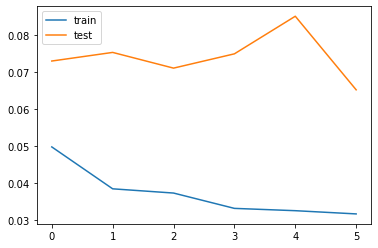

(74, 7)
(74, 7)
(74, 7)
score_train: [18.964] 18.2, 17.6, 18.8, 20.2, 19.7, 20.5, 17.6
(15, 1, 20)
score_test: [29.885] 31.7, 22.8, 46.5, 41.5, 24.9, 13.0, 6.7

RMSE test:  29.885177475580043 

gen	nevals	avg    	std	min    	max    
0  	10    	28.3912	0  	28.3912	28.3912

Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0668
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0633
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0584
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0540
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.0616
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0566
Model: "sequential_797"
_________________________________________________________________
Layer (

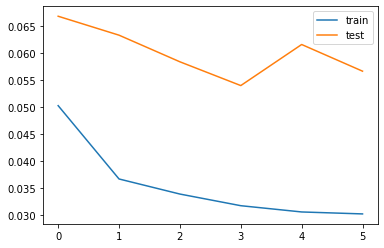

(74, 7)
(74, 7)
(74, 7)
score_train: [18.094] 16.5, 17.6, 18.1, 18.1, 19.3, 18.5, 18.6
(15, 1, 20)
score_test: [27.842] 27.7, 20.2, 43.8, 40.3, 23.6, 7.5, 9.7

RMSE test:  27.842290199477 


Units CNN1:  126 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0579 - val_loss: 0.0686
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0756
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0717
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0757
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.0844
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0599
Model: "sequential_798"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_798 (Conv1D)    

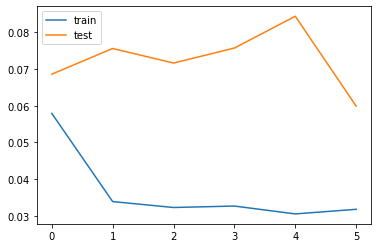

(74, 7)
(74, 7)
(74, 7)
score_train: [18.245] 16.7, 17.7, 19.8, 18.9, 18.3, 18.2, 18.0
(15, 1, 20)
score_test: [28.634] 30.7, 28.8, 39.6, 42.9, 23.0, 4.9, 1.3

RMSE test:  28.634198732729306 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0556 - val_loss: 0.0704
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0700
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0688
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0718
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0642
Epoch 6/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0320 - val_loss: 0.0661
Model: "sequential_799"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_799 (Conv1D) 

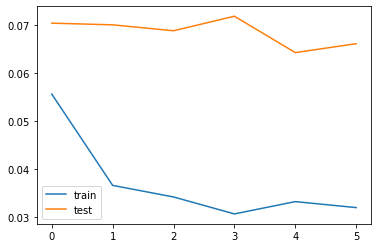

(74, 7)
(74, 7)
(74, 7)
score_train: [18.705] 16.7, 17.1, 18.7, 17.9, 19.6, 21.1, 19.5
(15, 1, 20)
score_test: [30.074] 29.5, 25.2, 44.3, 36.6, 28.6, 20.3, 17.1

RMSE test:  30.07434458825749 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0537 - val_loss: 0.0905
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0813
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0701
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0737
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0589
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0588
Model: "sequential_800"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_800 (Conv1D)

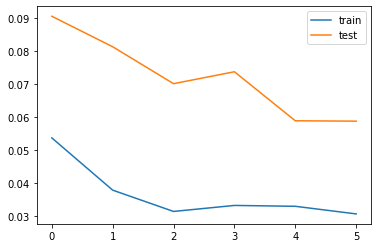

(74, 7)
(74, 7)
(74, 7)
score_train: [19.495] 20.9, 19.9, 18.5, 18.4, 21.2, 19.4, 18.0
(15, 1, 20)
score_test: [28.367] 27.6, 25.1, 42.5, 35.5, 30.6, 8.2, 13.1

RMSE test:  28.36734404807362 


Units CNN1:  111 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0528 - val_loss: 0.0724
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0398 - val_loss: 0.0740
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0792
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0725
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0607
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0294 - val_loss: 0.0645
Model: "sequential_801"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_801 (Conv1D) 

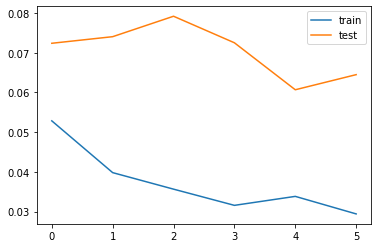

(74, 7)
(74, 7)
(74, 7)
score_train: [18.977] 16.7, 18.3, 21.5, 18.6, 20.0, 19.5, 17.9
(15, 1, 20)
score_test: [29.707] 34.6, 19.4, 40.6, 49.0, 21.2, 7.0, 7.6

RMSE test:  29.70740086231315 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0584 - val_loss: 0.0622
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0689
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0560
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0639
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0657
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0723
Model: "sequential_802"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_802 (Conv1D)  

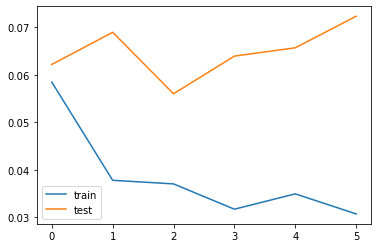

(74, 7)
(74, 7)
(74, 7)
score_train: [21.424] 20.4, 20.9, 25.5, 18.9, 22.2, 23.4, 17.5
(15, 1, 20)
score_test: [31.459] 33.5, 23.7, 51.8, 37.4, 30.5, 13.9, 7.2

RMSE test:  31.458744897892444 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0591 - val_loss: 0.0542
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0779
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0813
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0704
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0630
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0755
Model: "sequential_803"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_803 (Conv1D)

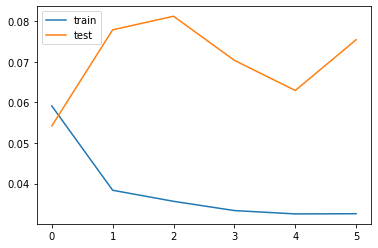

(74, 7)
(74, 7)
(74, 7)
score_train: [20.518] 17.5, 23.9, 25.1, 18.1, 19.0, 18.6, 20.2
(15, 1, 20)
score_test: [32.144] 36.6, 32.3, 48.3, 39.8, 25.4, 4.2, 16.5

RMSE test:  32.143714185723766 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0491 - val_loss: 0.0885
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0794
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.1026
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0896
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0610
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0639
Model: "sequential_804"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_804 (Conv1D)

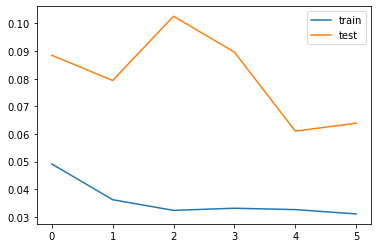

(74, 7)
(74, 7)
(74, 7)
score_train: [18.229] 17.2, 17.7, 18.0, 19.4, 19.3, 18.5, 17.2
(15, 1, 20)
score_test: [29.569] 31.1, 20.0, 43.3, 45.2, 25.4, 10.6, 8.7

RMSE test:  29.569062860013954 


Units CNN1:  63 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0633 - val_loss: 0.0603
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0563
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0705
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0548
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0601
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0469
Model: "sequential_805"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_805 (Conv1D) 

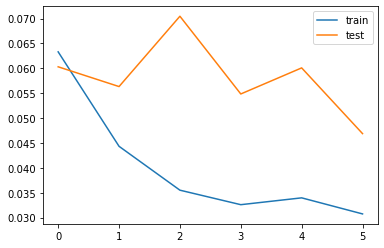

(74, 7)
(74, 7)
(74, 7)
score_train: [18.734] 16.8, 18.7, 17.9, 20.2, 20.2, 18.3, 18.8
(15, 1, 20)
score_test: [25.331] 30.2, 19.7, 39.2, 32.3, 19.8, 7.2, 12.8

RMSE test:  25.331073653814975 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0526 - val_loss: 0.0747
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0677
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0813
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0696
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0714
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0584
Model: "sequential_806"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_806 (Conv1D)

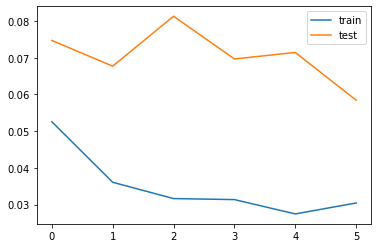

(74, 7)
(74, 7)
(74, 7)
score_train: [18.609] 17.0, 17.0, 21.1, 18.6, 19.5, 18.4, 18.3
(15, 1, 20)
score_test: [28.276] 29.7, 27.3, 43.4, 34.9, 26.4, 5.5, 11.6

RMSE test:  28.276431392703227 

1  	10    	27.34  	1.00449	25.3311	27.8423

Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0783 - val_loss: 0.1209
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0809
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0872
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.0770
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0742
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0692
Model: "sequential_807"
_________________________________________________________________
Layer (type)                 Output Shape 

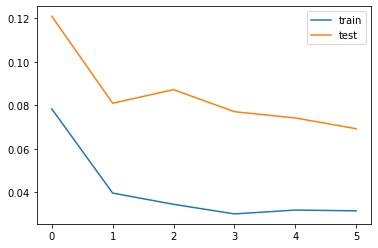

(74, 7)
(74, 7)
(74, 7)
score_train: [18.084] 16.9, 17.4, 18.4, 18.7, 19.3, 18.2, 17.7
(15, 1, 20)
score_test: [30.777] 40.7, 21.2, 46.6, 38.1, 28.4, 5.9, 7.8

RMSE test:  30.776553306205496 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0582 - val_loss: 0.0639
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.0687
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0603
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0702
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0589
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0523
Model: "sequential_808"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_808 (Conv1D) 

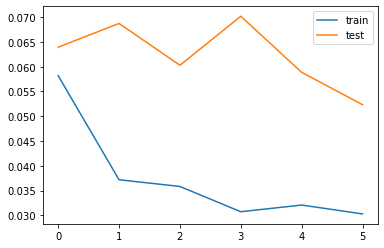

(74, 7)
(74, 7)
(74, 7)
score_train: [18.074] 17.1, 18.0, 18.3, 18.6, 18.1, 18.2, 18.2
(15, 1, 20)
score_test: [26.765] 25.7, 24.6, 39.3, 41.0, 19.4, 5.3, 10.9

RMSE test:  26.7654378348527 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0676 - val_loss: 0.0668
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0593
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0660
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0594
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0705
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0533
Model: "sequential_809"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_809 (Conv1D)  

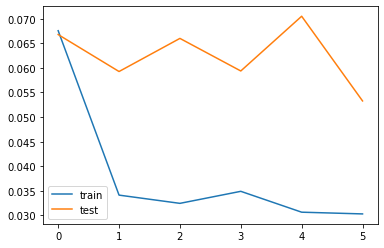

(74, 7)
(74, 7)
(74, 7)
score_train: [18.397] 17.5, 17.3, 18.5, 18.6, 18.3, 19.8, 18.6
(15, 1, 20)
score_test: [27.008] 38.4, 28.2, 39.4, 27.1, 19.9, 6.5, 10.5

RMSE test:  27.008161041610638 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0649 - val_loss: 0.0551
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0589
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0699
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0654
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0667
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0611
Model: "sequential_810"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_810 (Conv1D)

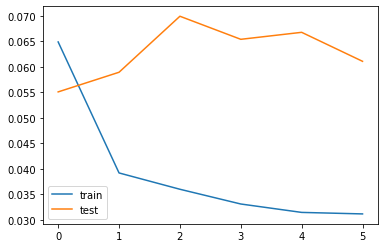

(74, 7)
(74, 7)
(74, 7)
score_train: [18.866] 19.7, 18.0, 19.3, 18.7, 19.9, 18.5, 18.0
(15, 1, 20)
score_test: [28.914] 26.5, 23.3, 46.8, 43.3, 20.9, 5.7, 8.3

RMSE test:  28.91367711087199 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 1s 14ms/step - loss: 0.0538 - val_loss: 0.0994
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0765
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0764
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0762
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0749
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0727
Model: "sequential_811"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_811 (Conv1D) 

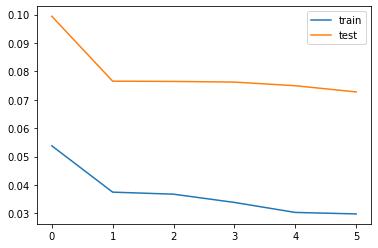

(74, 7)
(74, 7)
(74, 7)
score_train: [18.631] 17.2, 17.6, 18.0, 19.0, 19.2, 18.9, 20.2
(15, 1, 20)
score_test: [31.556] 41.8, 21.9, 45.3, 42.2, 23.4, 13.0, 13.9

RMSE test:  31.55569624116889 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0407 - val_loss: 0.0725
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0619
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0777
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0328 - val_loss: 0.0540
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0578
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0601
Model: "sequential_812"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_812 (Conv1D)

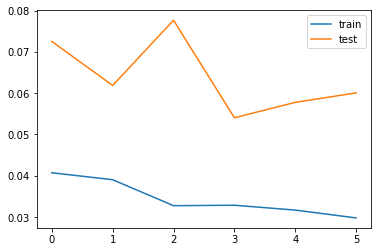

(74, 7)
(74, 7)
(74, 7)
score_train: [18.063] 16.4, 18.3, 18.5, 17.9, 18.7, 18.5, 18.0
(15, 1, 20)
score_test: [28.671] 31.0, 16.1, 42.1, 45.5, 24.2, 5.0, 9.3

RMSE test:  28.671484737367408 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0591 - val_loss: 0.0736
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0830
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0645
Epoch 4/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0349 - val_loss: 0.0743
Epoch 5/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0322 - val_loss: 0.0624
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0635
Model: "sequential_813"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_813 (Conv1D) 

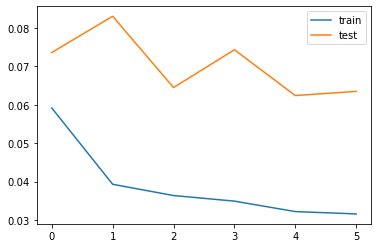

(74, 7)
(74, 7)
(74, 7)
score_train: [18.378] 17.0, 17.9, 18.3, 18.7, 19.3, 19.1, 18.3
(15, 1, 20)
score_test: [29.475] 32.4, 23.4, 44.4, 42.1, 24.1, 10.4, 7.4

RMSE test:  29.47522914665962 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0560 - val_loss: 0.0517
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0664
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0583
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0669
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.0582
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.0499
Model: "sequential_814"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_814 (Conv1D) 

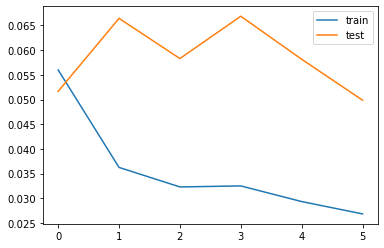

(74, 7)
(74, 7)
(74, 7)
score_train: [18.535] 17.0, 17.1, 18.0, 19.7, 19.9, 19.1, 18.8
(15, 1, 20)
score_test: [26.129] 27.1, 24.6, 39.3, 32.6, 24.1, 9.1, 13.1

RMSE test:  26.12929859665233 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0829
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0872
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0747
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0920
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0615
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0701
Model: "sequential_815"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_815 (Conv1D) 

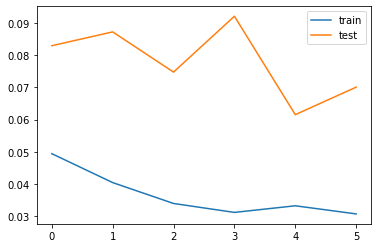

(74, 7)
(74, 7)
(74, 7)
score_train: [18.454] 16.5, 17.7, 19.3, 20.5, 18.6, 18.0, 18.4
(15, 1, 20)
score_test: [30.969] 29.0, 24.7, 42.8, 51.5, 24.4, 7.7, 11.0

RMSE test:  30.968800207063108 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0548 - val_loss: 0.0853
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.1030
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0734
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0711
Epoch 5/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0326 - val_loss: 0.0785
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.0682
Model: "sequential_816"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_816 (Conv1D)

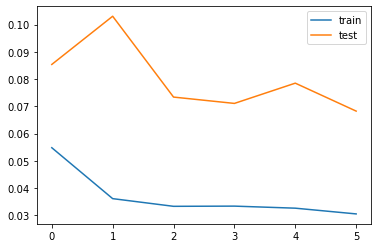

(74, 7)
(74, 7)
(74, 7)
score_train: [18.220] 16.9, 19.0, 18.2, 18.7, 18.1, 18.7, 17.7
(15, 1, 20)
score_test: [30.561] 36.3, 29.6, 46.2, 40.5, 20.4, 7.4, 9.5

RMSE test:  30.560934297474464 

2  	10    	25.3311	0      	25.3311	25.3311

Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0561 - val_loss: 0.0578
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0550
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0533
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0571
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0610
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0495
Model: "sequential_817"
_________________________________________________________________
Layer (type)                 Output Shape  

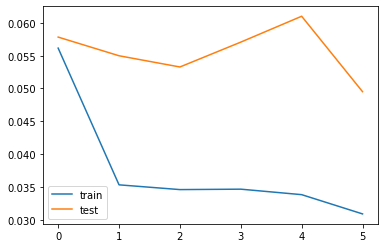

(74, 7)
(74, 7)
(74, 7)
score_train: [19.894] 16.7, 18.3, 23.3, 23.6, 18.7, 19.5, 18.1
(15, 1, 20)
score_test: [26.034] 24.1, 18.4, 51.4, 22.0, 26.1, 3.6, 2.9

RMSE test:  26.034305714426445 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0561 - val_loss: 0.0930
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0904
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0820
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0827
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0715
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0616
Model: "sequential_818"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_818 (Conv1D) 

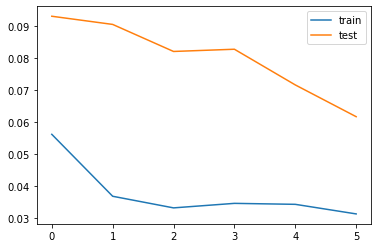

(74, 7)
(74, 7)
(74, 7)
score_train: [18.784] 18.0, 17.7, 18.0, 21.3, 19.0, 19.1, 18.1
(15, 1, 20)
score_test: [29.048] 38.5, 26.4, 46.5, 28.1, 24.2, 10.8, 7.9

RMSE test:  29.047504633645666 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0699 - val_loss: 0.0776
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0714
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0735
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0642
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0630
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0619
Model: "sequential_819"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_819 (Conv1D)

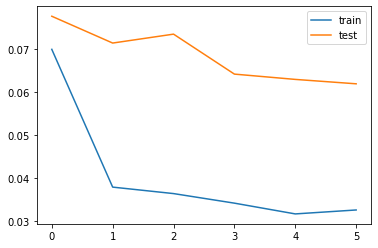

(74, 7)
(74, 7)
(74, 7)
score_train: [18.525] 16.8, 17.7, 20.0, 18.8, 19.1, 19.2, 17.8
(15, 1, 20)
score_test: [29.119] 31.3, 26.7, 44.4, 36.4, 29.0, 7.5, 7.1

RMSE test:  29.119222450533353 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0642
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0811
Epoch 3/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0349 - val_loss: 0.0725
Epoch 4/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0826
Epoch 5/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0329 - val_loss: 0.0646
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0589
Model: "sequential_820"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_820 (Conv1D) 

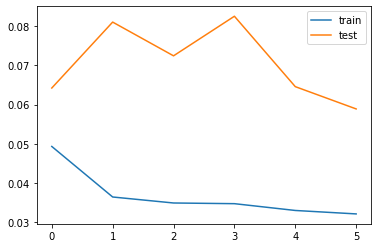

(74, 7)
(74, 7)
(74, 7)
score_train: [19.073] 18.5, 19.8, 19.9, 18.7, 19.7, 19.0, 17.8
(15, 1, 20)
score_test: [28.394] 20.4, 22.7, 40.9, 44.1, 30.3, 8.3, 10.4

RMSE test:  28.39409869519213 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0519 - val_loss: 0.0973
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.0793
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0804
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0874
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0658
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0633
Model: "sequential_821"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_821 (Conv1D) 

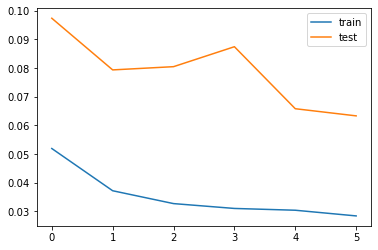

(74, 7)
(74, 7)
(74, 7)
score_train: [18.427] 16.7, 17.5, 17.6, 17.9, 20.3, 19.8, 18.9
(15, 1, 20)
score_test: [29.435] 33.4, 26.4, 43.4, 37.7, 23.8, 14.5, 12.9

RMSE test:  29.43527892782137 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0595 - val_loss: 0.0748
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0592
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0660
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0582
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0555
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.0602
Model: "sequential_822"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_822 (Conv1D)

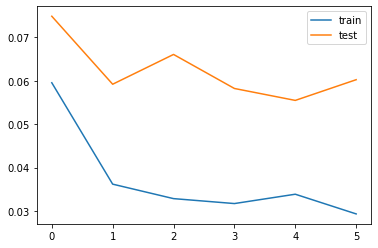

(74, 7)
(74, 7)
(74, 7)
score_train: [18.503] 16.6, 17.7, 20.8, 20.0, 18.4, 18.2, 17.6
(15, 1, 20)
score_test: [28.712] 31.9, 23.0, 42.2, 43.9, 19.9, 5.3, 9.8

RMSE test:  28.712328779677602 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0549 - val_loss: 0.0723
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0862
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0800
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0770
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0785
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0686
Model: "sequential_823"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_823 (Conv1D) 

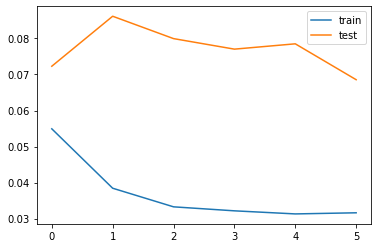

(74, 7)
(74, 7)
(74, 7)
score_train: [19.219] 17.6, 17.3, 18.3, 19.0, 21.1, 18.5, 22.2
(15, 1, 20)
score_test: [30.634] 35.9, 27.1, 45.2, 42.5, 21.6, 5.7, 13.8

RMSE test:  30.634357139652728 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0561 - val_loss: 0.0856
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0851
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0841
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0871
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0682
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0324 - val_loss: 0.0574
Model: "sequential_824"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_824 (Conv1D)

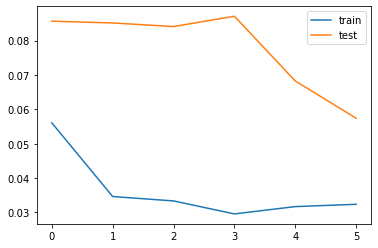

(74, 7)
(74, 7)
(74, 7)
score_train: [18.101] 17.0, 17.7, 18.4, 19.9, 18.3, 17.9, 17.4
(15, 1, 20)
score_test: [28.034] 34.0, 26.0, 44.4, 32.4, 23.4, 7.3, 7.3

RMSE test:  28.034422519782204 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0481 - val_loss: 0.0781
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0638
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0624
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0643
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0662
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0500
Model: "sequential_825"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_825 (Conv1D) 

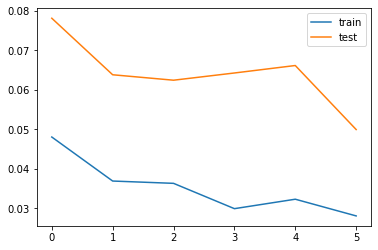

(74, 7)
(74, 7)
(74, 7)
score_train: [19.669] 17.5, 18.5, 18.1, 21.9, 22.2, 19.9, 19.1
(15, 1, 20)
score_test: [26.150] 29.6, 20.5, 41.1, 26.2, 28.9, 12.3, 11.6

RMSE test:  26.15012296500716 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0528 - val_loss: 0.0612
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0767
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0913
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0681
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0790
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0658
Model: "sequential_826"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_826 (Conv1D)

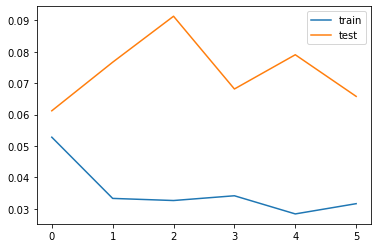

(74, 7)
(74, 7)
(74, 7)
score_train: [18.629] 17.4, 17.4, 18.4, 18.5, 18.9, 18.6, 21.0
(15, 1, 20)
score_test: [30.010] 37.6, 26.8, 46.0, 36.1, 24.7, 4.2, 11.2

RMSE test:  30.010408623556422 

3  	10    	25.3311	0      	25.3311	25.3311

Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0534 - val_loss: 0.0627
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0770
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0763
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0576
Epoch 5/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0322 - val_loss: 0.0627
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0626
Model: "sequential_827"
_________________________________________________________________
Layer (type)                 Output Shape 

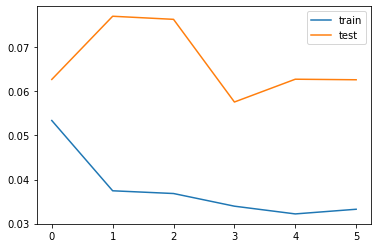

(74, 7)
(74, 7)
(74, 7)
score_train: [19.444] 19.4, 21.9, 19.3, 19.1, 19.6, 19.0, 17.5
(15, 1, 20)
score_test: [29.279] 33.9, 26.9, 43.9, 36.6, 23.7, 14.4, 9.9

RMSE test:  29.279360068381024 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0595 - val_loss: 0.0845
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0371 - val_loss: 0.0900
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0848
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0952
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0893
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0736
Model: "sequential_828"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_828 (Conv1D)

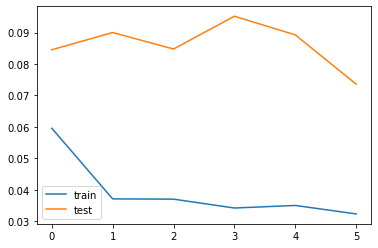

(74, 7)
(74, 7)
(74, 7)
score_train: [20.023] 19.6, 18.6, 18.9, 21.5, 22.0, 20.8, 18.5
(15, 1, 20)
score_test: [31.738] 41.5, 25.6, 48.4, 34.8, 26.2, 14.4, 15.2

RMSE test:  31.73810027907273 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0548 - val_loss: 0.0690
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.1025
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0734
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0688
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0691
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0635
Model: "sequential_829"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_829 (Conv1D)

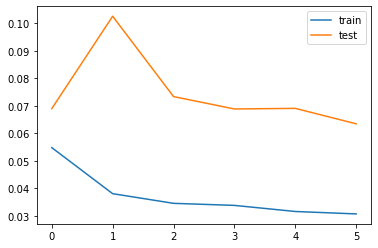

(74, 7)
(74, 7)
(74, 7)
score_train: [19.756] 19.2, 17.6, 20.2, 21.2, 19.7, 22.2, 17.9
(15, 1, 20)
score_test: [29.474] 31.3, 24.6, 45.8, 36.3, 25.8, 16.8, 11.6

RMSE test:  29.47427936052481 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0562 - val_loss: 0.1059
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0752
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0752
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0840
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0644
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0328 - val_loss: 0.0673
Model: "sequential_830"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_830 (Conv1D)

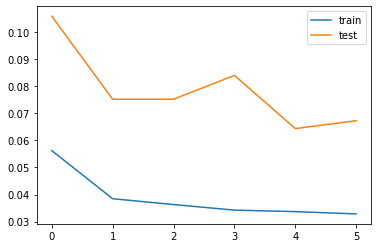

(74, 7)
(74, 7)
(74, 7)
score_train: [18.766] 17.8, 19.7, 21.3, 18.6, 18.3, 18.1, 17.3
(15, 1, 20)
score_test: [30.352] 29.2, 24.7, 47.4, 46.2, 22.0, 9.1, 5.4

RMSE test:  30.352168654732214 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0481 - val_loss: 0.0839
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0735
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0623
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0650
Epoch 5/6
74/74 [==============================] - 0s 4ms/step - loss: 0.0319 - val_loss: 0.0693
Epoch 6/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0303 - val_loss: 0.0679
Model: "sequential_831"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_831 (Conv1D) 

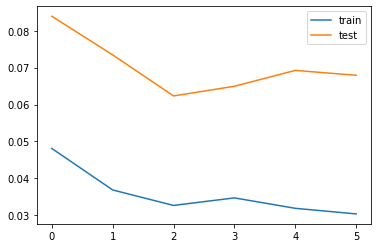

(74, 7)
(74, 7)
(74, 7)
score_train: [18.815] 16.3, 20.7, 18.4, 18.5, 19.1, 19.4, 19.0
(15, 1, 20)
score_test: [30.495] 28.1, 29.2, 47.1, 41.5, 23.9, 15.2, 11.3

RMSE test:  30.4946859155008 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0553 - val_loss: 0.0706
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0731
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0748
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0727
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0670
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0618
Model: "sequential_832"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_832 (Conv1D) 

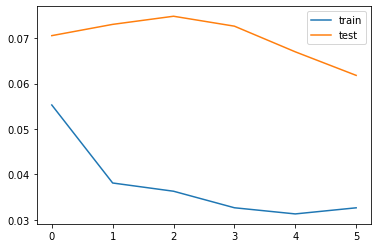

(74, 7)
(74, 7)
(74, 7)
score_train: [18.756] 17.3, 18.7, 18.4, 20.2, 19.4, 18.6, 18.6
(15, 1, 20)
score_test: [29.091] 33.6, 22.7, 47.0, 28.9, 32.9, 6.3, 10.6

RMSE test:  29.091172065261368 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 1s 14ms/step - loss: 0.0638 - val_loss: 0.1006
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0389 - val_loss: 0.1044
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0857
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0371 - val_loss: 0.0816
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0328 - val_loss: 0.0823
Epoch 6/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0307 - val_loss: 0.0673
Model: "sequential_833"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_833 (Conv1D

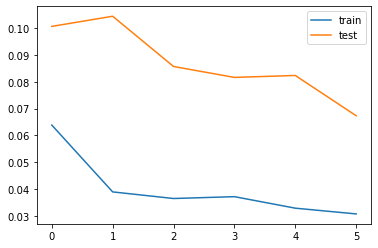

(74, 7)
(74, 7)
(74, 7)
score_train: [18.297] 17.1, 17.5, 18.7, 18.9, 19.3, 17.9, 18.5
(15, 1, 20)
score_test: [30.354] 30.2, 23.0, 40.4, 47.2, 29.2, 11.7, 12.2

RMSE test:  30.35376161543001 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0667 - val_loss: 0.0716
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0371 - val_loss: 0.0827
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0900
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0907
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0823
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0615
Model: "sequential_834"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_834 (Conv1D)

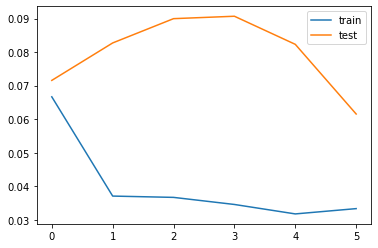

(74, 7)
(74, 7)
(74, 7)
score_train: [19.702] 17.5, 19.9, 20.6, 20.7, 18.6, 20.3, 20.1
(15, 1, 20)
score_test: [29.024] 28.5, 26.0, 46.9, 37.9, 23.5, 8.2, 12.3

RMSE test:  29.023661635749708 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0558 - val_loss: 0.1012
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0742
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0838
Epoch 4/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0338 - val_loss: 0.0668
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0586
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0565
Model: "sequential_835"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_835 (Conv1D)

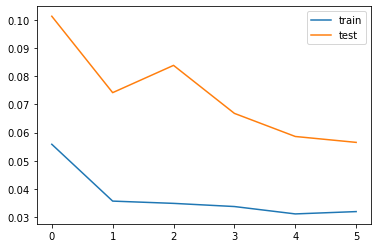

(74, 7)
(74, 7)
(74, 7)
score_train: [19.836] 16.3, 17.5, 21.4, 23.9, 18.9, 21.2, 18.6
(15, 1, 20)
score_test: [27.813] 28.9, 24.0, 47.0, 28.4, 26.2, 13.1, 11.6

RMSE test:  27.813262698318724 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0853 - val_loss: 0.0941
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0857
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0766
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0677
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0767
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0661
Model: "sequential_836"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_836 (Conv1D

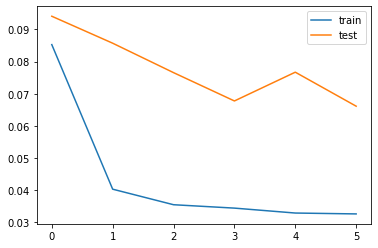

(74, 7)
(74, 7)
(74, 7)
score_train: [18.398] 17.2, 17.2, 18.9, 19.0, 18.3, 20.0, 17.9
(15, 1, 20)
score_test: [30.085] 28.7, 29.7, 48.2, 38.4, 21.6, 15.5, 11.3

RMSE test:  30.08526502703689 

4  	10    	25.3311	0      	25.3311	25.3311

Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0575 - val_loss: 0.0714
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0389 - val_loss: 0.0939
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0784
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0330 - val_loss: 0.0705
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0692
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0785
Model: "sequential_837"
_________________________________________________________________
Layer (type)                 Output Shape 

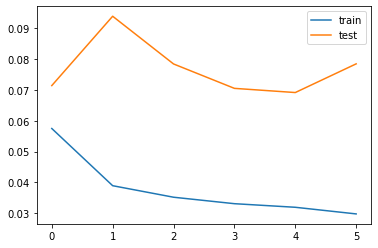

(74, 7)
(74, 7)
(74, 7)
score_train: [18.404] 17.7, 17.7, 18.2, 19.3, 19.1, 19.0, 17.7
(15, 1, 20)
score_test: [32.777] 41.3, 26.7, 46.7, 50.0, 16.6, 8.7, 8.6

RMSE test:  32.776848318025856 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0853
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0673
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0777
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0521
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0623
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0677
Model: "sequential_838"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_838 (Conv1D) 

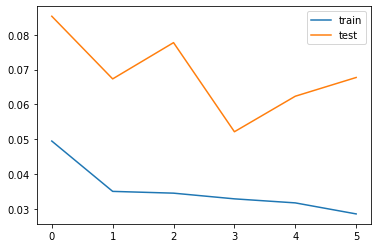

(74, 7)
(74, 7)
(74, 7)
score_train: [19.428] 18.2, 18.0, 18.6, 18.9, 18.4, 20.0, 23.3
(15, 1, 20)
score_test: [30.447] 29.3, 23.9, 44.0, 47.5, 22.5, 9.8, 16.2

RMSE test:  30.447363858036407 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0601 - val_loss: 0.0746
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0877
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0872
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0722
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0685
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0704
Model: "sequential_839"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_839 (Conv1D)

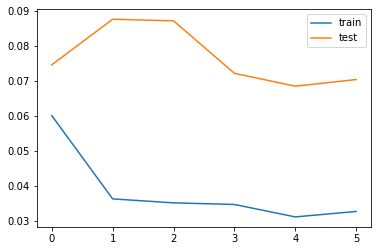

(74, 7)
(74, 7)
(74, 7)
score_train: [18.920] 17.7, 18.8, 20.0, 18.8, 19.0, 19.7, 18.3
(15, 1, 20)
score_test: [31.054] 30.1, 21.8, 48.6, 42.4, 26.0, 12.1, 19.8

RMSE test:  31.05438443078868 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0512 - val_loss: 0.0807
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0790
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0761
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0701
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0773
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0779
Model: "sequential_840"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_840 (Conv1D)

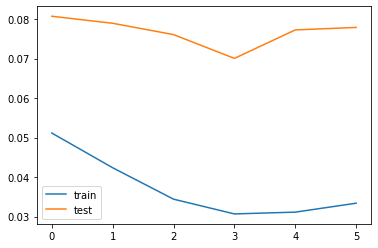

(74, 7)
(74, 7)
(74, 7)
score_train: [19.961] 17.7, 20.9, 20.5, 19.1, 19.5, 22.7, 18.9
(15, 1, 20)
score_test: [32.656] 28.7, 33.4, 48.3, 43.2, 24.4, 18.5, 19.7

RMSE test:  32.65641845212008 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0553 - val_loss: 0.0730
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0663
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0848
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0716
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0715
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0722
Model: "sequential_841"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_841 (Conv1D)

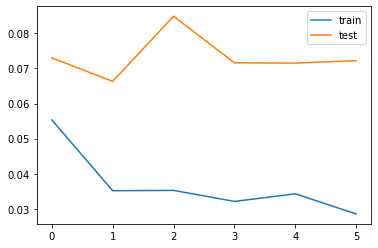

(74, 7)
(74, 7)
(74, 7)
score_train: [19.621] 17.4, 18.3, 19.5, 18.9, 24.4, 18.0, 20.1
(15, 1, 20)
score_test: [31.438] 37.1, 26.4, 46.9, 31.4, 36.3, 7.5, 17.0

RMSE test:  31.438249834264283 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0556 - val_loss: 0.0877
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0824
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0668
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0697
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0716
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0588
Model: "sequential_842"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_842 (Conv1D)

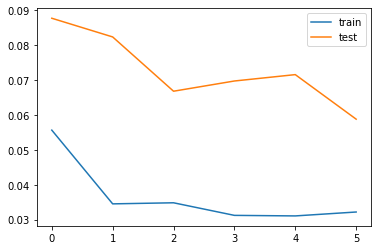

(74, 7)
(74, 7)
(74, 7)
score_train: [18.487] 18.5, 17.9, 17.4, 18.5, 18.8, 19.3, 18.8
(15, 1, 20)
score_test: [28.367] 27.5, 33.8, 44.8, 32.9, 21.9, 8.7, 9.8

RMSE test:  28.367291126298163 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0577 - val_loss: 0.0838
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0864
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0755
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0628
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0750
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0614
Model: "sequential_843"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_843 (Conv1D) 

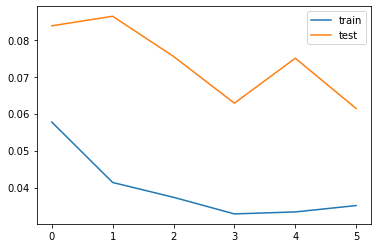

(74, 7)
(74, 7)
(74, 7)
score_train: [19.026] 17.4, 18.7, 18.2, 18.8, 20.9, 21.2, 17.5
(15, 1, 20)
score_test: [28.990] 26.8, 26.0, 41.7, 42.2, 27.8, 11.5, 7.8

RMSE test:  28.98961405364879 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0619 - val_loss: 0.0739
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0387 - val_loss: 0.0577
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0829
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0652
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0592
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.0810
Model: "sequential_844"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_844 (Conv1D) 

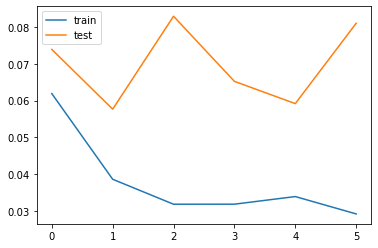

(74, 7)
(74, 7)
(74, 7)
score_train: [19.995] 20.4, 20.0, 18.1, 21.7, 19.3, 18.3, 21.7
(15, 1, 20)
score_test: [33.290] 42.1, 26.9, 41.6, 51.6, 24.5, 6.2, 15.1

RMSE test:  33.29029194159621 

5  	8     	25.3311	0      	25.3311	25.3311

Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0662 - val_loss: 0.0757
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0701
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0781
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0779
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0663
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0607
Model: "sequential_845"
_________________________________________________________________
Layer (type)                 Output Shape  

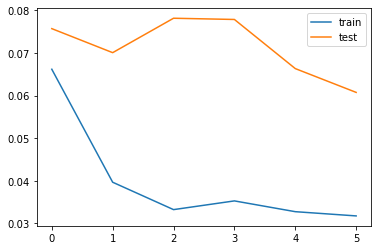

(74, 7)
(74, 7)
(74, 7)
score_train: [18.633] 16.4, 18.2, 18.4, 18.5, 22.8, 17.8, 17.8
(15, 1, 20)
score_test: [28.836] 30.7, 23.4, 41.0, 36.4, 30.2, 7.7, 18.6

RMSE test:  28.83648041594846 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0605 - val_loss: 0.0534
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0730
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0704
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0638
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0712
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0636
Model: "sequential_846"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_846 (Conv1D) 

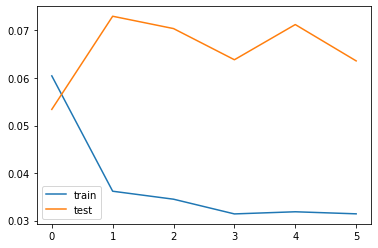

(74, 7)
(74, 7)
(74, 7)
score_train: [19.003] 17.8, 17.8, 22.2, 17.9, 19.0, 20.0, 17.9
(15, 1, 20)
score_test: [29.507] 30.4, 24.0, 46.6, 39.4, 26.0, 8.7, 11.2

RMSE test:  29.50694256665197 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.0710
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0758
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.0840
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0797
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0324 - val_loss: 0.0774
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0736
Model: "sequential_847"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_847 (Conv1D) 

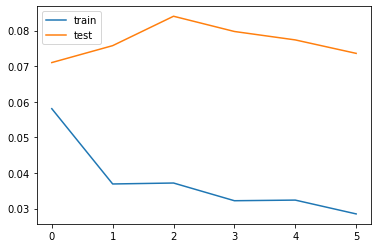

(74, 7)
(74, 7)
(74, 7)
score_train: [18.977] 17.7, 17.3, 20.9, 17.9, 18.9, 17.9, 21.8
(15, 1, 20)
score_test: [31.740] 42.5, 28.5, 40.7, 37.6, 31.0, 7.1, 18.7

RMSE test:  31.739735028500814 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0486 - val_loss: 0.0650
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0766
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0371 - val_loss: 0.0741
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0533
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0686
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0612
Model: "sequential_848"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_848 (Conv1D)

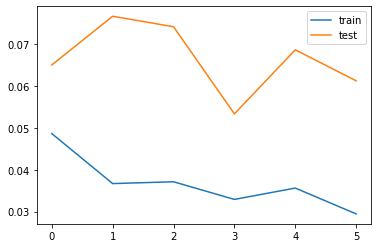

(74, 7)
(74, 7)
(74, 7)
score_train: [18.306] 16.7, 18.2, 18.6, 18.8, 18.2, 19.5, 18.0
(15, 1, 20)
score_test: [28.950] 29.9, 23.0, 43.5, 43.0, 19.8, 12.3, 12.8

RMSE test:  28.94983105377153 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0471 - val_loss: 0.0519
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0609
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0729
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0579
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0649
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.0518
Model: "sequential_849"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_849 (Conv1D)

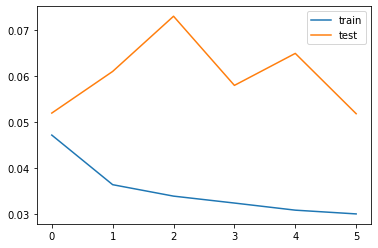

(74, 7)
(74, 7)
(74, 7)
score_train: [18.971] 16.9, 17.2, 18.5, 18.9, 19.5, 22.0, 19.3
(15, 1, 20)
score_test: [26.616] 28.0, 25.8, 41.4, 26.6, 25.6, 15.0, 14.5

RMSE test:  26.61602318012817 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0511 - val_loss: 0.1066
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0971
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0931
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0819
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0892
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0625
Model: "sequential_850"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_850 (Conv1D)

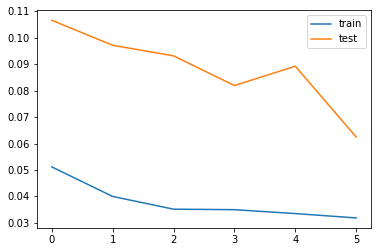

(74, 7)
(74, 7)
(74, 7)
score_train: [20.025] 19.2, 17.3, 18.9, 27.4, 18.9, 18.2, 18.5
(15, 1, 20)
score_test: [29.239] 38.5, 27.8, 45.9, 30.3, 20.9, 6.1, 15.3

RMSE test:  29.23923864259029 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0831
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0861
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0699
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0696
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0839
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0664
Model: "sequential_851"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_851 (Conv1D) 

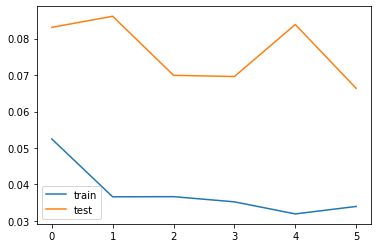

(74, 7)
(74, 7)
(74, 7)
score_train: [19.929] 18.8, 22.8, 20.1, 20.4, 20.2, 18.7, 17.9
(15, 1, 20)
score_test: [30.141] 27.8, 32.7, 47.7, 34.8, 27.6, 9.8, 13.3

RMSE test:  30.14147265940487 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0619
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0774
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0900
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0738
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0685
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0708
Model: "sequential_852"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_852 (Conv1D) 

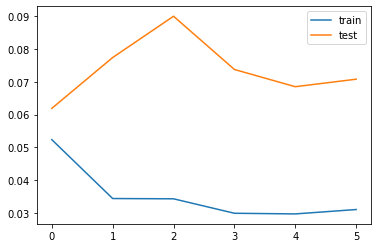

(74, 7)
(74, 7)
(74, 7)
score_train: [18.636] 16.4, 21.4, 19.2, 19.0, 19.1, 17.5, 17.5
(15, 1, 20)
score_test: [31.129] 24.8, 29.8, 42.6, 52.6, 24.9, 5.8, 6.4

RMSE test:  31.12915901428601 

6  	8     	25.3311	0      	25.3311	25.3311

Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0509 - val_loss: 0.0866
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0988
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0954
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0756
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0770
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.0697
Model: "sequential_853"
_________________________________________________________________
Layer (type)                 Output Shape   

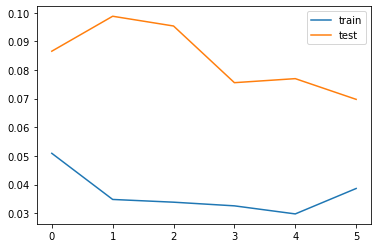

(74, 7)
(74, 7)
(74, 7)
score_train: [18.323] 16.7, 17.5, 18.2, 19.3, 18.9, 19.4, 18.1
(15, 1, 20)
score_test: [30.899] 37.2, 27.5, 47.4, 37.7, 22.4, 12.5, 14.6

RMSE test:  30.89887533453462 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0699 - val_loss: 0.0809
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0769
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0659
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0721
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.0719
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0640
Model: "sequential_854"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_854 (Conv1D)

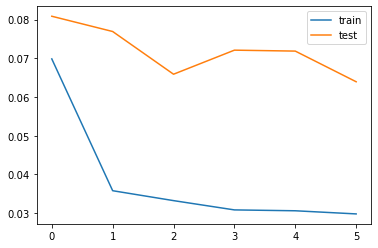

(74, 7)
(74, 7)
(74, 7)
score_train: [19.347] 17.5, 17.6, 18.8, 18.2, 19.9, 18.5, 24.2
(15, 1, 20)
score_test: [29.588] 28.5, 29.4, 44.8, 35.7, 28.2, 3.2, 18.9

RMSE test:  29.587680504280307 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 5ms/step - loss: 0.0558 - val_loss: 0.0728
Epoch 2/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0395 - val_loss: 0.0711
Epoch 3/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0339 - val_loss: 0.0693
Epoch 4/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0337 - val_loss: 0.0630
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0658
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0606
Model: "sequential_855"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_855 (Conv1D)

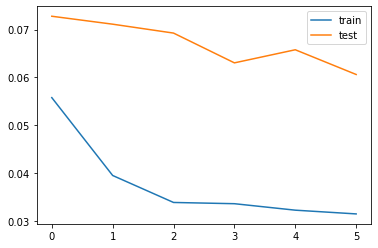

(74, 7)
(74, 7)
(74, 7)
score_train: [19.473] 17.3, 18.0, 20.5, 18.7, 20.7, 22.5, 18.1
(15, 1, 20)
score_test: [28.807] 28.9, 21.6, 40.3, 37.0, 29.5, 23.0, 10.6

RMSE test:  28.806774359352183 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0578 - val_loss: 0.0757
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0671
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0655
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0648
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0653
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0820
Model: "sequential_856"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_856 (Conv1D

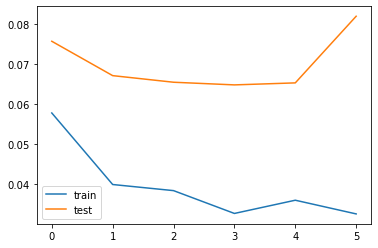

(74, 7)
(74, 7)
(74, 7)
score_train: [19.088] 17.5, 17.8, 17.3, 21.6, 20.3, 18.6, 20.0
(15, 1, 20)
score_test: [33.502] 35.9, 19.6, 42.9, 54.3, 32.8, 6.6, 16.4

RMSE test:  33.50236936551905 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0641 - val_loss: 0.0644
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0841
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0841
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0704
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0328 - val_loss: 0.0725
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0725
Model: "sequential_857"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_857 (Conv1D) 

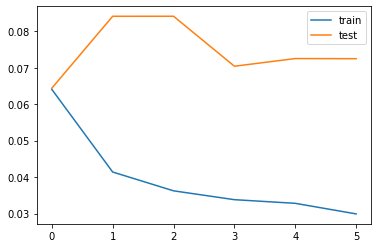

(74, 7)
(74, 7)
(74, 7)
score_train: [19.321] 17.0, 19.5, 18.3, 18.9, 19.3, 19.6, 22.1
(15, 1, 20)
score_test: [31.499] 32.6, 19.0, 41.7, 51.2, 28.2, 8.7, 17.0

RMSE test:  31.499327232776725 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0540 - val_loss: 0.0918
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0714
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0656
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.0976
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0582
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0645
Model: "sequential_858"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_858 (Conv1D)

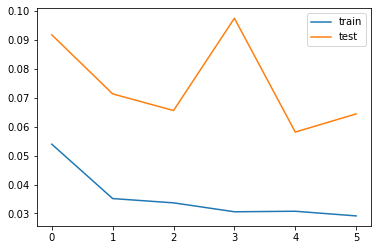

(74, 7)
(74, 7)
(74, 7)
score_train: [18.304] 16.5, 18.7, 18.1, 18.3, 19.2, 19.5, 17.7
(15, 1, 20)
score_test: [29.704] 26.7, 25.2, 41.2, 44.8, 31.3, 7.8, 8.8

RMSE test:  29.70354054134326 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0530 - val_loss: 0.0723
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0395 - val_loss: 0.0703
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0813
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0821
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0775
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0825
Model: "sequential_859"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_859 (Conv1D)  

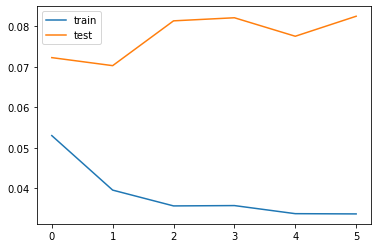

(74, 7)
(74, 7)
(74, 7)
score_train: [19.854] 18.0, 18.2, 18.4, 23.6, 19.9, 20.0, 20.4
(15, 1, 20)
score_test: [33.603] 30.3, 22.8, 42.6, 58.6, 29.9, 6.4, 16.8

RMSE test:  33.602804175503685 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0530 - val_loss: 0.0716
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0650
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0665
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0641
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.0581
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0619
Model: "sequential_860"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_860 (Conv1D)

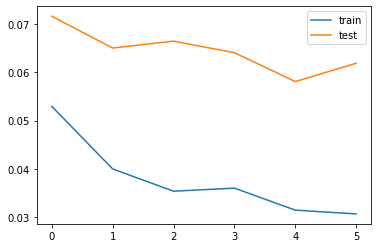

(74, 7)
(74, 7)
(74, 7)
score_train: [19.476] 23.1, 17.5, 18.8, 18.9, 20.9, 18.1, 18.5
(15, 1, 20)
score_test: [29.107] 36.2, 21.9, 43.5, 35.4, 24.5, 7.9, 18.1

RMSE test:  29.107038238992605 

7  	8     	25.3311	0      	25.3311	25.3311

Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0467 - val_loss: 0.0740
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0747
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0756
Epoch 4/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0631
Epoch 5/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0306 - val_loss: 0.0686
Epoch 6/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0311 - val_loss: 0.0697
Model: "sequential_861"
_________________________________________________________________
Layer (type)                 Output Shape 

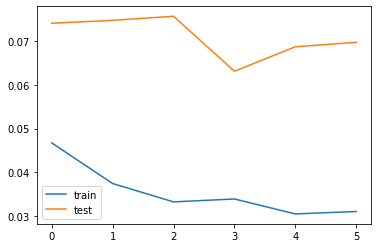

(74, 7)
(74, 7)
(74, 7)
score_train: [18.805] 16.7, 19.0, 19.2, 18.9, 19.8, 20.0, 17.7
(15, 1, 20)
score_test: [30.881] 30.9, 31.2, 43.0, 46.0, 23.8, 13.8, 5.1

RMSE test:  30.880607509863566 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0457 - val_loss: 0.0650
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0566
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0693
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0674
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0760
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0562
Model: "sequential_862"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_862 (Conv1D)

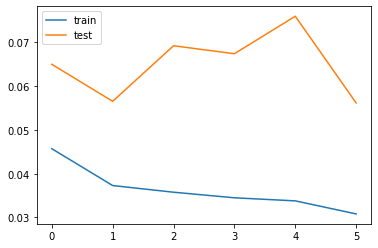

(74, 7)
(74, 7)
(74, 7)
score_train: [18.757] 17.3, 18.2, 19.1, 21.1, 18.9, 18.4, 18.0
(15, 1, 20)
score_test: [27.730] 36.4, 24.4, 41.6, 32.3, 23.7, 7.3, 9.0

RMSE test:  27.730237287624078 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0569 - val_loss: 0.0580
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0837
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0652
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0759
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0665
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0324 - val_loss: 0.0645
Model: "sequential_863"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_863 (Conv1D) 

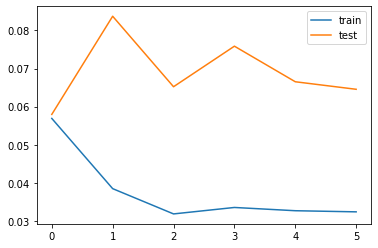

(74, 7)
(74, 7)
(74, 7)
score_train: [18.576] 19.3, 18.0, 18.1, 18.5, 18.8, 19.4, 17.9
(15, 1, 20)
score_test: [29.725] 35.6, 26.7, 46.9, 35.3, 26.7, 5.3, 3.8

RMSE test:  29.724545828410786 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0590
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0645
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0501
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0614
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0518
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0526
Model: "sequential_864"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_864 (Conv1D) 

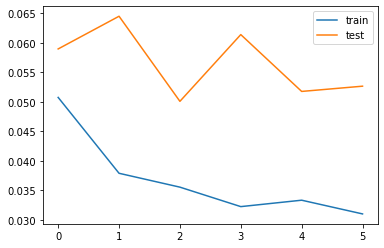

(74, 7)
(74, 7)
(74, 7)
score_train: [18.703] 18.7, 17.6, 20.1, 18.0, 19.2, 18.9, 18.3
(15, 1, 20)
score_test: [26.846] 24.8, 25.1, 46.2, 33.8, 22.0, 3.0, 6.1

RMSE test:  26.846097158752368 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0562 - val_loss: 0.0802
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0724
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0671
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0708
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0708
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0544
Model: "sequential_865"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_865 (Conv1D) 

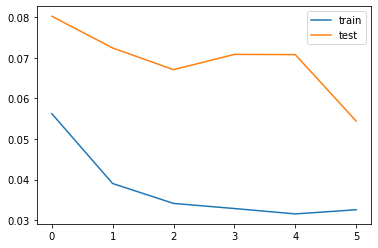

(74, 7)
(74, 7)
(74, 7)
score_train: [18.551] 17.2, 18.3, 19.9, 18.0, 19.5, 18.9, 17.8
(15, 1, 20)
score_test: [27.290] 31.7, 14.6, 38.8, 40.9, 27.8, 2.5, 5.6

RMSE test:  27.290110399784712 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0538 - val_loss: 0.0945
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0768
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0324 - val_loss: 0.0677
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0664
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0294 - val_loss: 0.0650
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.0690
Model: "sequential_866"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_866 (Conv1D) 

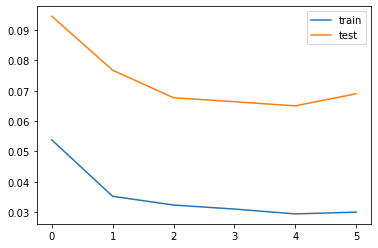

(74, 7)
(74, 7)
(74, 7)
score_train: [18.623] 17.7, 17.3, 18.3, 19.9, 20.1, 19.1, 17.7
(15, 1, 20)
score_test: [30.733] 36.2, 23.8, 43.1, 46.3, 23.2, 7.4, 11.9

RMSE test:  30.732973511708586 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0653 - val_loss: 0.0765
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0711
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0591
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0720
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0550
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0630
Model: "sequential_867"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_867 (Conv1D)

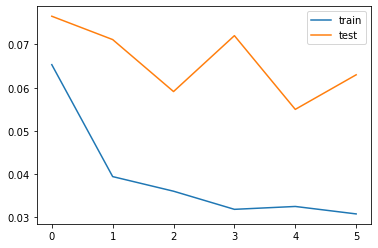

(74, 7)
(74, 7)
(74, 7)
score_train: [20.851] 18.3, 19.0, 23.5, 18.8, 23.1, 18.8, 23.5
(15, 1, 20)
score_test: [29.364] 30.1, 27.4, 40.6, 41.2, 25.5, 11.1, 16.2

RMSE test:  29.36364798176731 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0585 - val_loss: 0.0713
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0696
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0631
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0674
Epoch 5/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0305 - val_loss: 0.0769
Epoch 6/6
74/74 [==============================] - 0s 5ms/step - loss: 0.0317 - val_loss: 0.0565
Model: "sequential_868"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_868 (Conv1D)

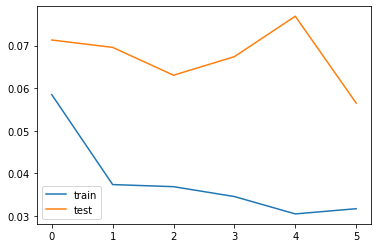

(74, 7)
(74, 7)
(74, 7)
score_train: [18.495] 17.9, 18.0, 18.8, 18.4, 19.0, 19.1, 18.2
(15, 1, 20)
score_test: [27.815] 34.3, 25.9, 38.4, 34.4, 24.9, 11.1, 12.9

RMSE test:  27.8151330666535 

8  	8     	25.3311	0      	25.3311	25.3311

Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0522 - val_loss: 0.0831
Epoch 2/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0376 - val_loss: 0.0850
Epoch 3/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0381 - val_loss: 0.0743
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0981
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0724
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0794
Model: "sequential_869"
_________________________________________________________________
Layer (type)                 Output Shape  

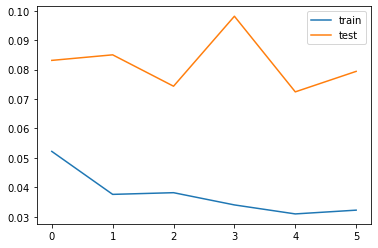

(74, 7)
(74, 7)
(74, 7)
score_train: [18.952] 17.2, 17.7, 19.2, 19.4, 19.3, 21.1, 18.6
(15, 1, 20)
score_test: [32.966] 38.7, 27.5, 45.2, 46.5, 25.7, 19.2, 10.8

RMSE test:  32.966485483446704 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0449 - val_loss: 0.0535
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0692
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0820
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0609
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0543
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0692
Model: "sequential_870"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_870 (Conv1D

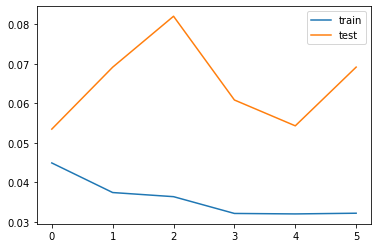

(74, 7)
(74, 7)
(74, 7)
score_train: [19.847] 17.0, 19.5, 21.9, 20.3, 22.0, 19.1, 18.6
(15, 1, 20)
score_test: [30.772] 29.6, 27.6, 39.5, 53.5, 17.2, 4.2, 15.7

RMSE test:  30.771890249066875 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0636 - val_loss: 0.0776
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0559
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0707
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0652
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0531
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0560
Model: "sequential_871"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_871 (Conv1D)

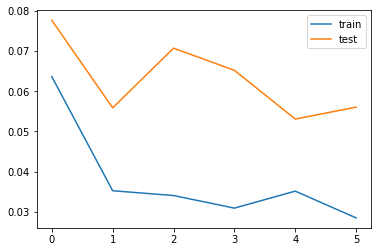

(74, 7)
(74, 7)
(74, 7)
score_train: [18.141] 17.3, 17.7, 18.2, 18.3, 18.8, 19.1, 17.6
(15, 1, 20)
score_test: [27.692] 32.2, 23.3, 42.3, 38.8, 19.4, 4.2, 9.7

RMSE test:  27.69229011895322 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0519 - val_loss: 0.0759
Epoch 2/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0370 - val_loss: 0.0710
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0614
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0589
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0564
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0544
Model: "sequential_872"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_872 (Conv1D)  

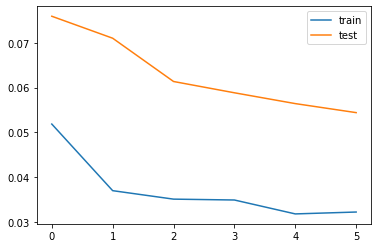

(74, 7)
(74, 7)
(74, 7)
score_train: [19.406] 17.4, 23.5, 19.0, 19.5, 19.4, 18.9, 17.6
(15, 1, 20)
score_test: [27.296] 28.6, 27.3, 40.9, 31.6, 27.1, 9.9, 12.3

RMSE test:  27.29618058818327 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0532 - val_loss: 0.0726
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0707
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0817
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0640
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.0528
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0443
Model: "sequential_873"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_873 (Conv1D) 

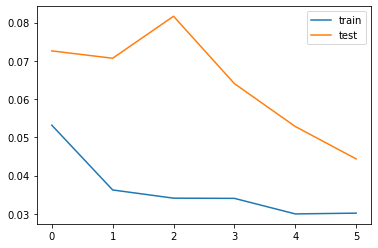

(74, 7)
(74, 7)
(74, 7)
score_train: [18.030] 16.2, 18.0, 17.8, 18.9, 18.5, 18.6, 18.0
(15, 1, 20)
score_test: [24.639] 23.3, 22.6, 39.3, 34.8, 17.6, 8.1, 7.9

RMSE test:  24.63856403103413 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0647 - val_loss: 0.0742
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0838
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0768
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0854
Epoch 5/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0322 - val_loss: 0.0702
Epoch 6/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0306 - val_loss: 0.0668
Model: "sequential_874"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_874 (Conv1D)  

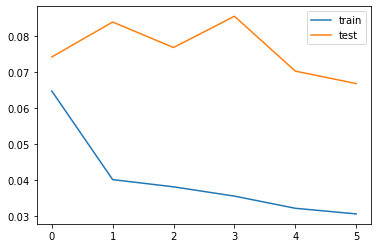

(74, 7)
(74, 7)
(74, 7)
score_train: [20.086] 19.3, 25.4, 18.5, 20.0, 19.0, 19.7, 17.8
(15, 1, 20)
score_test: [30.233] 30.3, 31.6, 40.5, 45.9, 24.9, 6.3, 8.7

RMSE test:  30.232834731058304 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 5ms/step - loss: 0.0580 - val_loss: 0.0422
Epoch 2/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0384 - val_loss: 0.0640
Epoch 3/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0638
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0571
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0583
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.0618
Model: "sequential_875"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_875 (Conv1D) 

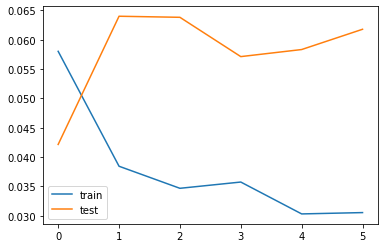

(74, 7)
(74, 7)
(74, 7)
score_train: [19.415] 17.3, 22.3, 21.2, 19.5, 18.9, 18.0, 18.2
(15, 1, 20)
score_test: [29.081] 26.9, 29.3, 41.7, 43.3, 22.8, 9.1, 11.1

RMSE test:  29.081114449422202 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0511 - val_loss: 0.0738
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.0775
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0708
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0716
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.0647
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0669
Model: "sequential_876"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_876 (Conv1D)

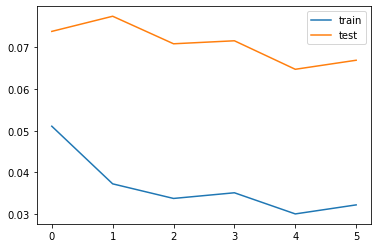

(74, 7)
(74, 7)
(74, 7)
score_train: [18.414] 18.8, 18.7, 17.8, 18.9, 18.6, 17.9, 18.1
(15, 1, 20)
score_test: [30.262] 36.0, 26.1, 42.3, 42.0, 23.4, 4.8, 17.6

RMSE test:  30.2622977890486 

9  	8     	25.0541	0.339259	24.6386	25.3311

Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0667 - val_loss: 0.0551
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0573
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0798
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0685
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0673
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0611
Model: "sequential_877"
_________________________________________________________________
Layer (type)                 Output Shape  

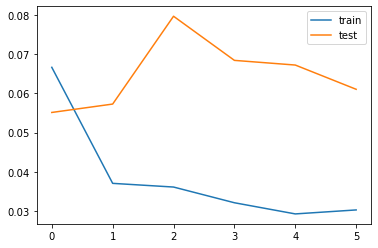

(74, 7)
(74, 7)
(74, 7)
score_train: [19.667] 20.1, 17.2, 19.3, 22.2, 20.2, 19.2, 19.2
(15, 1, 20)
score_test: [28.915] 35.9, 25.9, 47.2, 24.7, 27.8, 7.2, 15.1

RMSE test:  28.914820547441753 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 1s 15ms/step - loss: 0.0570 - val_loss: 0.0786
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0742
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0882
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0699
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0695
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0771
Model: "sequential_878"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_878 (Conv1D

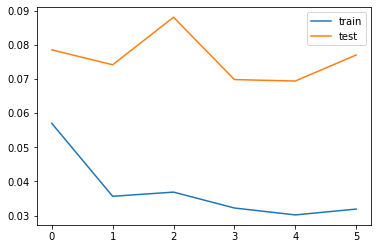

(74, 7)
(74, 7)
(74, 7)
score_train: [19.724] 16.4, 18.4, 24.0, 22.3, 19.4, 18.0, 18.4
(15, 1, 20)
score_test: [32.486] 28.7, 28.1, 41.3, 57.1, 26.4, 8.4, 6.0

RMSE test:  32.48598213840813 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0571 - val_loss: 0.0727
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0632
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0659
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0710
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0668
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0324 - val_loss: 0.0698
Model: "sequential_879"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_879 (Conv1D)  

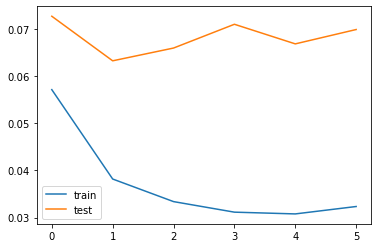

(74, 7)
(74, 7)
(74, 7)
score_train: [18.294] 16.9, 17.8, 18.7, 19.3, 19.0, 18.5, 17.7
(15, 1, 20)
score_test: [30.922] 30.7, 23.9, 43.0, 49.2, 27.5, 6.4, 10.5

RMSE test:  30.9216602222857 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0562 - val_loss: 0.0978
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0668
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0740
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0314 - val_loss: 0.1038
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0602
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0635
Model: "sequential_880"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_880 (Conv1D)  

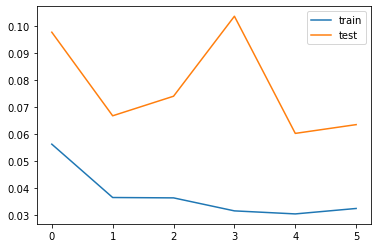

(74, 7)
(74, 7)
(74, 7)
score_train: [19.149] 17.2, 17.8, 20.4, 18.3, 19.5, 18.4, 22.0
(15, 1, 20)
score_test: [29.481] 33.8, 24.0, 39.1, 39.4, 25.4, 9.2, 23.6

RMSE test:  29.480972544275623 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0521 - val_loss: 0.0692
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0573
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0672
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0712
Epoch 5/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0323 - val_loss: 0.0586
Epoch 6/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0306 - val_loss: 0.0571
Model: "sequential_881"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_881 (Conv1D)

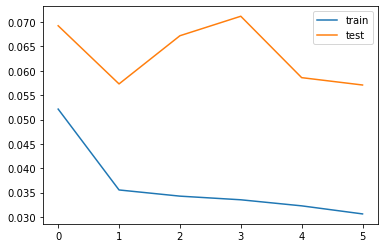

(74, 7)
(74, 7)
(74, 7)
score_train: [18.760] 17.0, 18.5, 18.2, 19.7, 20.5, 18.9, 18.4
(15, 1, 20)
score_test: [27.953] 36.9, 29.9, 40.4, 31.5, 18.7, 8.9, 12.5

RMSE test:  27.953348390210177 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0537 - val_loss: 0.0620
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0638
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0660
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0533
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0507
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.0609
Model: "sequential_882"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_882 (Conv1D)

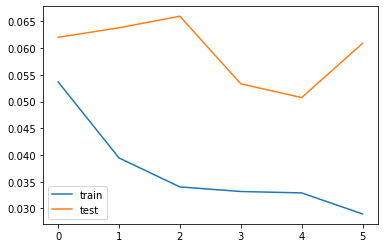

(74, 7)
(74, 7)
(74, 7)
score_train: [18.635] 17.4, 17.6, 18.3, 20.7, 19.3, 18.7, 18.2
(15, 1, 20)
score_test: [28.871] 28.8, 27.2, 39.7, 43.2, 22.8, 10.9, 13.7

RMSE test:  28.871196764397194 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0660 - val_loss: 0.0549
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0785
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0745
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0718
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0590
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0684
Model: "sequential_883"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_883 (Conv1D

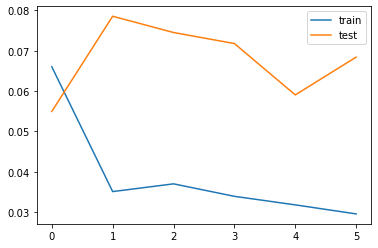

(74, 7)
(74, 7)
(74, 7)
score_train: [19.276] 16.5, 20.4, 20.0, 18.6, 20.6, 20.1, 18.3
(15, 1, 20)
score_test: [30.598] 32.6, 27.9, 42.4, 41.7, 27.2, 18.1, 10.4

RMSE test:  30.598260518478313 


Units CNN1:  127 ,Sequence size:  4
(74, 1, 20)
Epoch 1/6
74/74 [==============================] - 0s 3ms/step - loss: 0.0578 - val_loss: 0.0669
Epoch 2/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0757
Epoch 3/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0727
Epoch 4/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0771
Epoch 5/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0702
Epoch 6/6
74/74 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0780
Model: "sequential_884"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_884 (Conv1D

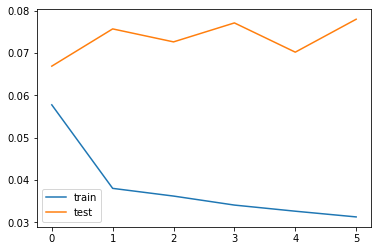

(74, 7)
(74, 7)
(74, 7)
score_train: [18.733] 18.0, 18.7, 19.2, 19.6, 18.5, 18.7, 18.5
(15, 1, 20)
score_test: [32.680] 42.8, 22.3, 45.6, 47.6, 20.8, 9.5, 16.8

RMSE test:  32.67967132291186 

10 	8     	24.6386	0       	24.6386	24.6386


In [639]:
population_size = 10
num_generations = 10
# 8 bits for ltsm1 , 8 for lstm 2 , 6 for sequence length , 21 for features selections
# 8 bits for cnn1 ,8 bits for cnn2 , 8 bits for lstm 2 ,8 bits for lstm 2 , 6 bits for sequence length , 21 for features selections
gene_length =8 #58

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.9)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.7)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)
population = toolbox.population(n = population_size)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
#param cxpb: The probability of mating two individuals.
#param mutpb: The probability of mutating an individual.
population , logbook  = algorithms.eaSimple(population, toolbox,halloffame=hof, cxpb = 0.7, mutpb = 0.6,stats=stats, ngen = num_generations, verbose = True)

In [640]:
print('Best score :', best_score)

Best score : 24.63856403103413


In [641]:
model=model_name
model.summary()

Model: "sequential_873"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_873 (Conv1D)          (None, 1, 127)            5207      
_________________________________________________________________
flatten_873 (Flatten)        (None, 127)               0         
_________________________________________________________________
dropout_576 (Dropout)        (None, 127)               0         
_________________________________________________________________
dense_873 (Dense)            (None, 7)                 896       
Total params: 6,103
Trainable params: 6,103
Non-trainable params: 0
_________________________________________________________________


In [642]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# make a prediction
yhat = model.predict(X_test[[0,7,14]])
yhat.shape 

(3, 7)

In [643]:
yhat = yhat.reshape(-1, yhat.shape[-1])

In [644]:
#yhat

In [645]:
# invert scaling for forecast
y_test_pred = scaler2.inverse_transform(yhat)
#print(inv_yhat)
# invert scaling for actual
Y_test_true =Y_test[[0,7,14]]
Y_test_true = Y_test_true.reshape(-1, Y_test_true.shape[-1])
y_test_true= scaler2.inverse_transform(Y_test_true)
#print(inv_y)

In [646]:
days

DatetimeIndex(['2020-05-25', '2020-05-26', '2020-05-27', '2020-05-28',
               '2020-05-29', '2020-05-30', '2020-05-31', '2020-06-01',
               '2020-06-02', '2020-06-03', '2020-06-04', '2020-06-05',
               '2020-06-06', '2020-06-07', '2020-06-08', '2020-06-09',
               '2020-06-10', '2020-06-11', '2020-06-12', '2020-06-13',
               '2020-06-14'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

In [647]:
test_res=pd.DataFrame()
test_res['Prediction']=y_test_pred.flatten()[0:21]
test_res['real']=y_test_true.flatten()[0:21]
test_res.set_index(days,inplace=True)

In [648]:
test_res

,Prediction,real
timestamp,,
2020-05-25,59.327549,27.0
2020-05-26,80.017952,99.0
2020-05-27,65.749664,45.0
2020-05-28,63.766964,24.0
2020-05-29,58.689320,42.0
2020-05-30,69.652580,71.0
2020-05-31,76.233871,66.0
2020-06-01,46.668663,27.0
2020-06-02,60.173870,26.0


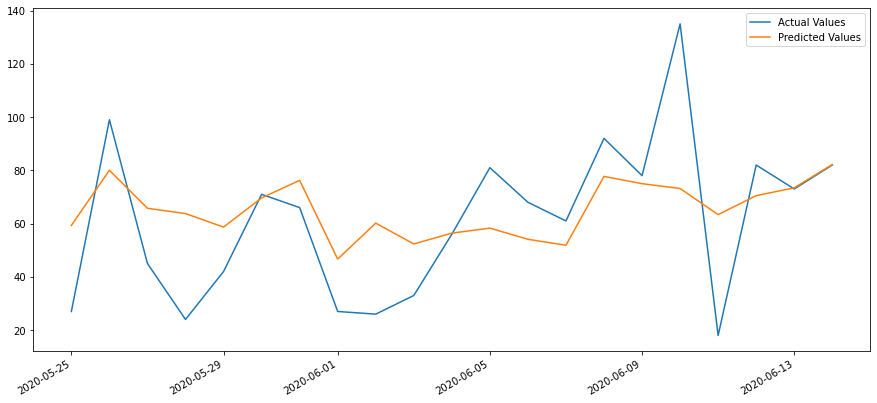

In [649]:

import pandas as pd
import numpy as np; np.random.seed(1)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,7))
plt.plot(test_res.index, test_res['real'],  label='Actual Values')
plt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')
# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()




In [650]:
import numpy as np 
from sklearn import metrics
print('Test Metrics')
print('MSE:', round(metrics.mean_squared_error(test_res['real'], test_res['Prediction']), 2))
print('RMSE:',round( np.sqrt(metrics.mean_squared_error(test_res['real'], test_res['Prediction'])), 2))
print('MAE:', round(metrics.mean_absolute_error(test_res['real'], test_res['Prediction']), 2))
print('R Squared:', round( metrics.r2_score(test_res['real'], test_res['Prediction']), 2))
print('Max Error:',round(  metrics.max_error(test_res['real'], test_res['Prediction']), 2))


Test Metrics
MSE: 607.06
RMSE: 24.64
MAE: 18.86
R Squared: 0.29
Max Error: 61.82


In [651]:
# make a prediction
y_train_pred = model.predict(X_train)
y_train_pred .shape

(74, 7)

In [652]:
y_train_pred = y_train_pred.reshape(y_train_pred.shape[0], y_train_pred.shape[1])
y_train_pred.shape

(74, 7)

In [653]:

# invert scaling for forecast

y_train_pred = scaler2.inverse_transform(y_train_pred)
Y_train_true = Y_train.reshape((len(Y_train), n_out))

y_train_real = scaler2.inverse_transform(Y_train_true )

In [654]:

# Flatten for final errors
Y_train_pred_bis = y_train_pred.flatten()
Y_train_real_bis = y_train_real.flatten()

In [655]:
y_train_pred[0]

array([23.440441, 25.77844 , 25.006855, 26.756144, 26.820513, 30.498817,
       27.331467], dtype=float32)

In [656]:
#For plot 
#filter_indices = [0,6,13,20,27,34,41,48,55,62,69,76,83,90,97,104]
filter_indices = [0,6,13,20,27,34,41,48,55,62,69]
y_train_pred = y_train_pred [filter_indices ]

In [657]:
# Part of train dataset
y_train_real= y_train_real[filter_indices]
Y_train_pred = y_train_pred.flatten()
Y_train_real = y_train_real.flatten()

In [658]:
mask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))
date_train = df.loc[mask].date.sort_index(axis = 0) 
X_train.shape

(74, 1, 20)

In [659]:
date_train.head(7)

22661   2020-03-02
22662   2020-03-03
22663   2020-03-04
22664   2020-03-05
22665   2020-03-06
22666   2020-03-07
22667   2020-03-08
Name: date, dtype: datetime64[ns]

In [660]:
taille_x = date_train.shape[0] - nb_seq
taille_x 

80

In [661]:
date_train = date_train.values.flatten()

In [662]:
prediction_train = pd.DataFrame(columns=['date_to_prediction','true_value','predict'])

In [663]:
Y_train_pred.shape

(77,)

In [664]:
Y_train_real.shape

(77,)

In [665]:
date_train.shape

(84,)

In [666]:
date_train[nb_seq:].shape

(80,)

In [667]:
suite_size = Y_train_real.shape[0]- date_train[nb_seq:].shape[0]
suite_size 

-3

In [668]:
Y_train_real[:-suite_size].shape

(3,)

In [669]:
date_train[nb_seq:].shape

(80,)

In [670]:
Y_train_pred[:-suite_size].shape

(3,)

In [671]:
Y_train_real[:-suite_size].shape

(3,)

In [672]:
date_trainX = date_train[nb_seq:]

In [673]:
date_trainX[0:Y_train_pred.shape[0]].shape

(77,)

In [674]:
prediction_train['date_to_prediction'] = date_trainX[0:Y_train_pred.shape[0]]
prediction_train['predict'] = Y_train_pred
prediction_train['true_value'] = Y_train_real


In [675]:
prediction_train['date_to_prediction'] = pd.to_datetime(prediction_train['date_to_prediction'], infer_datetime_format=True)

In [676]:
prediction_train.set_index('date_to_prediction',inplace=True)

In [677]:
prediction_train.head(20)

,true_value,predict
date_to_prediction,,
2020-03-06,18.416370,23.440441
2020-03-07,20.498219,25.778440
2020-03-08,20.498219,25.006855
2020-03-09,20.498219,26.756144
2020-03-10,20.498219,26.820513
2020-03-11,20.498219,30.498817
2020-03-12,19.249111,27.331467
2020-03-13,19.249111,24.625912
2020-03-14,18.416370,24.381020


In [678]:
prediction_train.tail(10)

,true_value,predict
date_to_prediction,,
2020-05-12,81.704620,80.581139
2020-05-13,108.768677,70.793373
2020-05-14,75.042702,67.076744
2020-05-15,57.138786,80.084778
2020-05-16,57.555161,77.874741
2020-05-17,36.736652,75.022552
2020-05-18,55.056934,62.834492
2020-05-19,71.711739,75.323448
2020-05-20,52.142349,62.652107


"\nfig, ax = plt.subplots(figsize=(15,7))\nplt.plot(test_res.index, test_res['real'],  label='Actual Values')\nplt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')\n# If you don't like the break in the graph, change 90 to 89 in the above line\nplt.gcf().autofmt_xdate()\nplt.legend()\nplt.show()\n"

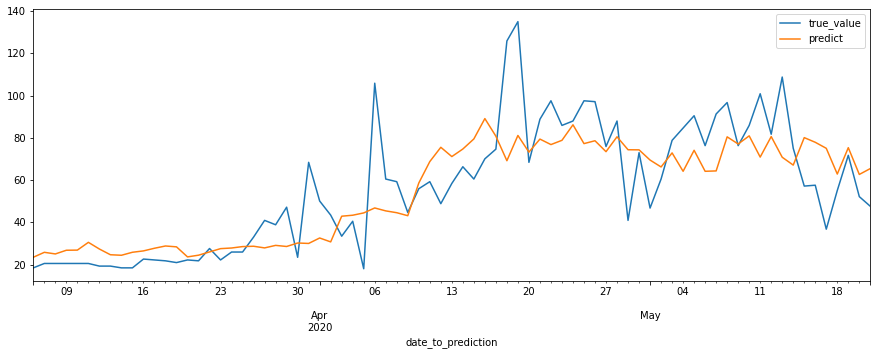

In [679]:
# Prédiction du train vs la réalité 
prediction_train.plot(figsize=(15,5))
'''
fig, ax = plt.subplots(figsize=(15,7))
plt.plot(test_res.index, test_res['real'],  label='Actual Values')
plt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')
# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()
'''

In [680]:
print('Trains Metrics')
loss = tf.keras.losses.mean_squared_error(Y_train_real_bis, Y_train_pred_bis )
print('MSE',"{:.2f}".format(loss))
rmse = tf.sqrt(tf.losses.mean_squared_error(Y_train_real_bis, Y_train_pred_bis ))
print('RMSE',"{:.2f}".format(rmse))
loss2 = tf.keras.losses.MAE(Y_train_real_bis, Y_train_pred_bis )
print('MAE',"{:.2f}".format(loss2))
r2 =r2_score(Y_train_real_bis, Y_train_pred_bis )
print('R2',"{:.2f}".format(r2))
maxerror=max_error(Y_train_real_bis, Y_train_pred_bis )
print('maxError',"{:.2f}".format(maxerror))

Trains Metrics
MSE 325.10
RMSE 18.03
MAE 12.77
R2 0.61
maxError 69.04
